In [1]:
#from pypads.app.base import PyPads
from datetime import datetime  

# CIFAR 10 dataset - Numpy
#import os
import platform
import pickle

import numpy as np
from numpy import asarray
from numpy import save
from numpy import load

import torch  
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
class VGG_11(nn.Module):
    
    def __init__(self):
        super(VGG_11,self).__init__()
        
        # Setting up the layers of Convolutional neural network
        in_size = 3                 # number of channel in the input image
    
        hid1_size = 64              # no of output channel from first CNN layer

        hid2_size = 128             # no of output channel from second CNN layer

        hid3_size = 256             # no of output channel from third CNN layer

        hid4_size = 512             # no of output channel from forth CNN layer

        classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

        out_size = len(classes)     # no of categories in the dataset

        k_conv_size = 3             # 3x3 convolutional kernel

        conv_stride = 1             # conv stride 1

        conv_pad = 1                # conv padding 1

        maxpool_kernel = 2          # maxpool layer kernel size 2 x 2

        maxpool_stride = 2          # maxpool layer stride 2

        self.convLayer = nn.Sequential(
            nn.Conv2d(in_size, hid1_size, k_conv_size, stride=conv_stride, padding=conv_pad),    # conv layer
            nn.BatchNorm2d(hid1_size),
            #nn.LocalResponseNorm(64),
            nn.ReLU(),                              # Activation layer
            nn.MaxPool2d(kernel_size=maxpool_kernel,stride=maxpool_stride),
            
            nn.Conv2d(hid1_size,hid2_size,k_conv_size, stride=conv_stride, padding=conv_pad),
            nn.BatchNorm2d(hid2_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=maxpool_kernel,stride=maxpool_stride),
            
            nn.Conv2d(hid2_size,hid3_size,k_conv_size, stride=conv_stride, padding=conv_pad),
            nn.BatchNorm2d(hid3_size),
            nn.ReLU(),
            
            nn.Conv2d(hid3_size,hid3_size,k_conv_size, stride=conv_stride, padding=conv_pad),
            nn.BatchNorm2d(hid3_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=maxpool_kernel,stride=maxpool_stride),
            
            nn.Conv2d(hid3_size,hid4_size,k_conv_size, stride=conv_stride, padding=conv_pad),
            nn.BatchNorm2d(hid4_size),
            nn.ReLU(),
            
            nn.Conv2d(hid4_size,hid4_size,k_conv_size, stride=conv_stride, padding=conv_pad),
            nn.BatchNorm2d(hid4_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=maxpool_kernel,stride=maxpool_stride),
            
            nn.Conv2d(hid4_size,hid4_size,k_conv_size, stride=conv_stride, padding=conv_pad),
            nn.BatchNorm2d(hid4_size),
            nn.ReLU(),
            
            nn.Conv2d(hid4_size,hid4_size,k_conv_size, stride=conv_stride, padding=conv_pad),
            nn.BatchNorm2d(hid4_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=maxpool_kernel,stride=maxpool_stride), 
            
            nn.Flatten(),
            
            nn.Linear(512, out_size)
            
        )
        
            
        
    def forward(self,x):
            out = self.convLayer(x)
            
            return out 
        
vgg_11 = VGG_11()

In [3]:
# Unpickle a data item
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

# Load CIFAR-10 batch
def load_CIFAR_batch(filename):
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000,3,32,32)
        Y = np.array(Y)
        return X, Y   

# Load full CIFAR-10 dataset
def load_CIFAR10(ROOT):
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte


def get_CIFAR10_data(num_training=49000, num_validation=0, num_test=10000):
    # Load the raw CIFAR-10 data
    dirname = os.path.dirname(__file__)
    cifar10_dir = 'CIFAR-10-DS/cifar-10-batches-py/'
    filename = os.path.join(dirname, cifar10_dir)
    
    X_train, y_train, X_test, y_test = load_CIFAR10(filename)

    num_training=X_train.shape[0]
    num_test=X_test.shape[0]

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    x_train = X_train.astype('float32')
    x_test = X_test.astype('float32')

    x_train /= 255
    x_test /= 255

    #Save dataset in npy files
    save('train_data.npy', x_train)
    save('train_label.npy', y_train)

    save('test_data.npy', x_test)
    save('test_label.npy', y_test)

    # Loading from npy files
    x_train = load('train_data.npy')
    y_train = load('train_label.npy')

    x_test = load('test_data.npy')
    y_test = load('test_label.npy')

    #Shuffle data 
    data = list(zip(x_train, y_train))
    np.random.shuffle(data)
    x_train, y_train = zip(*data)

    # Save the shuffled data
    save('train_data.npy', x_train)
    save('train_label.npy', y_train)

    #return x_train, y_train, x_test, y_test 

In [4]:
#Create custom size batches of the dataset
def createBatches(data,batch_size_required,device="cpu"):
    batch_size = int(len(data)/batch_size_required)
    res=[]
    
    for i in range (batch_size):
        batched_data = data[i*batch_size_required:i*batch_size_required+batch_size_required]
        res.append(batched_data)


    if (device == "cpu"):
        res = np.asarray(res)

    elif (device == "cuda"):
        return res
    
    return res


def useLossFunction():
    criterion = nn.CrossEntropyLoss()
    return criterion

In [5]:
def useOptimizerFunction(name, learning_rate=0.01, momentum_val = 0.9):
    #learning_rate = 0.01                        # Learning rate
    #momentum_val = 0.9                          # Momentum value
    print('learning rate ', learning_rate)
    optimizer=''
    if(name == 'Adadelta'):
        optimizer = optim.Adadelta(vgg_11.parameters())

    elif(name=='SGD'):
        optimizer = optim.SGD(vgg_11.parameters(), lr=learning_rate, momentum=momentum_val)
    
    elif(name=='NAG'):
        optimizer = optim.SGD(vgg_11.parameters(), lr=learning_rate, momentum=momentum_val, dampening=0, weight_decay=0, nesterov=True)

    return optimizer

In [6]:
running_loss_arr = []

def trainNetwork(max_epoch, x_train_tensor,y_train_tensor,optimizer,lossFun,dev):
    print('dev ', dev)
    for epoch in range(max_epoch):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(x_train_tensor, 0):

            inputs = data
            labels = y_train_tensor[i]
            optimizer.zero_grad()

            outputs = vgg_11(inputs)
            
            labels = labels.to(device=dev, dtype=torch.int64)
            
            loss = lossFun(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss_arr += loss.item()
            
            # print statistics        
            if i % 100 == 99:    # print every 100 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 100))

                running_loss = 0.0

    print('Finished Training')

In [7]:

def trainNetworkOnGPU(max_epoch, x_train_tensor,y_train_tensor,optimizer,lossFun,dev):
    print('dev ', dev)
    loss_value = []
    if(dev.type == "cuda"):
        for epoch in range(max_epoch):  # loop over the dataset multiple times

            running_loss = 0.0
            for i, data in enumerate(x_train_tensor, 0):

                inputs = data
                #input.cuda()

                labels = y_train_tensor[i]
                labels.cuda()

                optimizer.zero_grad()

                vgg_11_gpu = vgg_11.cuda()
                outputs = vgg_11_gpu(inputs)
                
                labels = labels.to(device=dev, dtype=torch.int64)
                
                loss = lossFun(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                loss_value.append(running_loss)
                # print statistics        
                if i % 100 == 99:    # print every 100 mini-batches
                    print('[%d, %5d] loss: %.10f' %
                        (epoch + 1, i + 1, running_loss / 100))
                    
                    running_loss = 0.0

        print('Finished Training on GPU')
        return loss_value
    else:
        print('GPU not present')

In [8]:
#Accuracy of individual classes and overall dataset
def AccuracyOfIndividualClassesAndDataset(x_test_t,y_test_t,bs):
    
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    with torch.no_grad():
        for i, data in enumerate(x_test_t, 0):
            #images, labels = data

            images = data
            labels = y_test_t[i]

            outputs = vgg_11(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                
                class_correct[int(label.item())] += c[i].item()
                class_total[int(label.item())] += 1


    for i in range(10):
        print('Accuracy of %5s : %.2f %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
    
    print('Accuracy of the network on the %d test images: %.2f %%' % (len(y_test_t)*bs,100 * correct / total))

In [9]:
def saveTrainedModel(name):
    if (name):
        PATH = './' + name + '.pth'
    else:
         PATH = './cifar_vgg11.pth'

    
    torch.save(vgg_11.state_dict(), PATH)

In [10]:
#Main function
begin_time = datetime.now()   

# Initializing pypads
#tracker = PyPads( autostart=True)
#tracker.start_track(experiment_name="Effect of GPUs - VGG 11")

torch.manual_seed(0)            # to set same random number to all devices [4]

device = torch.device("cpu")
max_epoch_num = 150               # Maximun numbe of epochs

#Get train and test dataset
#get_CIFAR10_data()

# Load dataset from npy files
x_train = load('/home/rgb/Documents/Thesis_Git/effects-of-cpu-and-gpu-architectures-on-the-accuracy-of-neural-networks/Code/VGG-11/train_data.npy')
y_train = load('/home/rgb/Documents/Thesis_Git/effects-of-cpu-and-gpu-architectures-on-the-accuracy-of-neural-networks/Code/VGG-11/train_label.npy')

x_test = load('/home/rgb/Documents/Thesis_Git/effects-of-cpu-and-gpu-architectures-on-the-accuracy-of-neural-networks/Code/VGG-11/test_data.npy')
y_test = load('/home/rgb/Documents/Thesis_Git/effects-of-cpu-and-gpu-architectures-on-the-accuracy-of-neural-networks/Code/VGG-11/test_label.npy')

#Divide the dataset into small batches
batch_size = 64
x_train = createBatches(x_train,batch_size)
y_train = createBatches(y_train,batch_size)

x_test = createBatches(x_test,batch_size)
y_test = createBatches(y_test,batch_size)


# Convert npArray to tensor
x_train_tensor = torch.as_tensor(x_train)
y_train_tensor = torch.as_tensor(y_train)

x_test_tensor = torch.as_tensor(x_test)
y_test_tensor = torch.as_tensor(y_test)

criterion = useLossFunction()

# Adadelta Optimizer
# optimizer=useOptimizerFunction('Adadelta')
# trainNetwork(max_epoch_num, x_train_tensor,y_train_tensor,optimizer,criterion,device)
# AccuracyOfIndividualClassesAndDataset(x_test_tensor,y_test_tensor,batch_size)

# # SGD Optimizer
# optimizer=useOptimizerFunction('SGD')
# trainNetwork(max_epoch_num, x_train_tensor,y_train_tensor,optimizer,criterion,device)
# AccuracyOfIndividualClassesAndDataset(x_test_tensor,y_test_tensor,batch_size)

# # NAG optimzer
# optimizer=useOptimizerFunction('NAG')
# trainNetwork(max_epoch_num, x_train_tensor,y_train_tensor,optimizer,criterion,device)
# AccuracyOfIndividualClassesAndDataset(x_test_tensor,y_test_tensor,batch_size)


print('Time required to run the model on CPU is', datetime.now() - begin_time)

Time required to run the model on CPU is 0:00:00.304329


learning rate  0.01
dev  cuda
[1,   100] loss: 2.0158778989
[1,   200] loss: 1.4998526537
[1,   300] loss: 1.2960635579
[1,   400] loss: 1.2110544711
[1,   500] loss: 1.0847582722
[1,   600] loss: 1.0334336948
[1,   700] loss: 0.9888960987
[2,   100] loss: 0.8925177485
[2,   200] loss: 0.8839610767
[2,   300] loss: 0.8010777617
[2,   400] loss: 0.7833276394
[2,   500] loss: 0.7597288772
[2,   600] loss: 0.7206210241
[2,   700] loss: 0.7166977456
[3,   100] loss: 0.6588169521
[3,   200] loss: 0.6624514690
[3,   300] loss: 0.5991278633
[3,   400] loss: 0.5852212387
[3,   500] loss: 0.5736099580
[3,   600] loss: 0.5414791757
[3,   700] loss: 0.5576477391
[4,   100] loss: 0.4950951105
[4,   200] loss: 0.5260245231
[4,   300] loss: 0.4733265132
[4,   400] loss: 0.4453386515
[4,   500] loss: 0.4613711292
[4,   600] loss: 0.4307808677
[4,   700] loss: 0.4497826621
[5,   100] loss: 0.3837221913
[5,   200] loss: 0.3975719030
[5,   300] loss: 0.3865358202
[5,   400] loss: 0.3387289225
[5,   500]

[39,   100] loss: 0.0000159296
[39,   200] loss: 0.0000173877
[39,   300] loss: 0.0000152244
[39,   400] loss: 0.0000152037
[39,   500] loss: 0.0000143871
[39,   600] loss: 0.0000157232
[39,   700] loss: 0.0000168459
[40,   100] loss: 0.0000150134
[40,   200] loss: 0.0000163845
[40,   300] loss: 0.0000144046
[40,   400] loss: 0.0000144027
[40,   500] loss: 0.0000135993
[40,   600] loss: 0.0000148741
[40,   700] loss: 0.0000159799
[41,   100] loss: 0.0000142125
[41,   200] loss: 0.0000155027
[41,   300] loss: 0.0000136789
[41,   400] loss: 0.0000136926
[41,   500] loss: 0.0000129050
[41,   600] loss: 0.0000141218
[41,   700] loss: 0.0000152089
[42,   100] loss: 0.0000135022
[42,   200] loss: 0.0000147209
[42,   300] loss: 0.0000130313
[42,   400] loss: 0.0000130594
[42,   500] loss: 0.0000122858
[42,   600] loss: 0.0000134519
[42,   700] loss: 0.0000145172
[43,   100] loss: 0.0000128689
[43,   200] loss: 0.0000140233
[43,   300] loss: 0.0000124484
[43,   400] loss: 0.0000124881
[43,   5

[76,   700] loss: 0.0000060539
[77,   100] loss: 0.0000053446
[77,   200] loss: 0.0000057146
[77,   300] loss: 0.0000052301
[77,   400] loss: 0.0000053759
[77,   500] loss: 0.0000049399
[77,   600] loss: 0.0000054423
[77,   700] loss: 0.0000059577
[78,   100] loss: 0.0000052601
[78,   200] loss: 0.0000056226
[78,   300] loss: 0.0000051471
[78,   400] loss: 0.0000052931
[78,   500] loss: 0.0000048624
[78,   600] loss: 0.0000053573
[78,   700] loss: 0.0000058641
[79,   100] loss: 0.0000051786
[79,   200] loss: 0.0000055331
[79,   300] loss: 0.0000050664
[79,   400] loss: 0.0000052128
[79,   500] loss: 0.0000047877
[79,   600] loss: 0.0000052745
[79,   700] loss: 0.0000057727
[80,   100] loss: 0.0000050992
[80,   200] loss: 0.0000054465
[80,   300] loss: 0.0000049883
[80,   400] loss: 0.0000051352
[80,   500] loss: 0.0000047145
[80,   600] loss: 0.0000051938
[80,   700] loss: 0.0000056855
[81,   100] loss: 0.0000050237
[81,   200] loss: 0.0000053629
[81,   300] loss: 0.0000049132
[81,   4

[114,   300] loss: 0.0000032996
[114,   400] loss: 0.0000034456
[114,   500] loss: 0.0000031380
[114,   600] loss: 0.0000034559
[114,   700] loss: 0.0000037778
[115,   100] loss: 0.0000033640
[115,   200] loss: 0.0000035484
[115,   300] loss: 0.0000032674
[115,   400] loss: 0.0000034139
[115,   500] loss: 0.0000031084
[115,   600] loss: 0.0000034231
[115,   700] loss: 0.0000037414
[116,   100] loss: 0.0000033324
[116,   200] loss: 0.0000035137
[116,   300] loss: 0.0000032363
[116,   400] loss: 0.0000033821
[116,   500] loss: 0.0000030793
[116,   600] loss: 0.0000033904
[116,   700] loss: 0.0000037063
[117,   100] loss: 0.0000033015
[117,   200] loss: 0.0000034803
[117,   300] loss: 0.0000032056
[117,   400] loss: 0.0000033509
[117,   500] loss: 0.0000030505
[117,   600] loss: 0.0000033588
[117,   700] loss: 0.0000036711
[118,   100] loss: 0.0000032707
[118,   200] loss: 0.0000034473
[118,   300] loss: 0.0000031755
[118,   400] loss: 0.0000033203
[118,   500] loss: 0.0000030216
[118,   

Finished Training on GPU
Accuracy of plane : 90.91 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 79.75 %
Accuracy of   cat : 64.38 %
Accuracy of  deer : 80.00 %
Accuracy of   dog : 79.31 %
Accuracy of  frog : 91.07 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 84.62 %
Accuracy of the network on the 9984 test images: 83.68 %
Time required to run the model on GPU is 0:52:22.412317


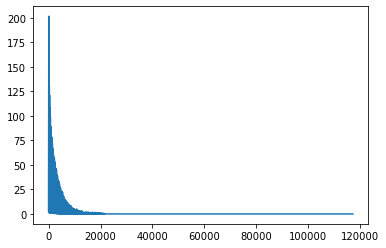

In [11]:
# If GPU is present run the code on the GPU 
begin_time = datetime.now()  

x_train_gpu = []
y_train_gpu = []
x_test_gpu = []
y_test_gpu = []
    
if (torch.cuda.is_available()):

    device = torch.device('cuda')  
    # Load data from the numpy files into tensor which are stored on GPU
    x_train_gpu = torch.FloatTensor(load('/home/rgb/Documents/Thesis_Git/effects-of-cpu-and-gpu-architectures-on-the-accuracy-of-neural-networks/Code/VGG-11/train_data.npy')).cuda()
    y_train_gpu = torch.FloatTensor(load('/home/rgb/Documents/Thesis_Git/effects-of-cpu-and-gpu-architectures-on-the-accuracy-of-neural-networks/Code/VGG-11/train_label.npy')).cuda()
    x_test_gpu = torch.FloatTensor(load('/home/rgb/Documents/Thesis_Git/effects-of-cpu-and-gpu-architectures-on-the-accuracy-of-neural-networks/Code/VGG-11/test_data.npy')).cuda()
    y_test_gpu = torch.FloatTensor(load('/home/rgb/Documents/Thesis_Git/effects-of-cpu-and-gpu-architectures-on-the-accuracy-of-neural-networks/Code/VGG-11/test_label.npy')).cuda()

    #Store model on GPU
    #vgg_11 = VGG_11.cuda()

    #Divide the dataset into small batches'
    x_train_gpu = createBatches(x_train_gpu,batch_size, "cuda")
    y_train_gpu = createBatches(y_train_gpu,batch_size, "cuda")

    x_test_gpu = createBatches(x_test_gpu,batch_size, "cuda")
    y_test_gpu = createBatches(y_test_gpu,batch_size, "cuda")


    # Adadelta Optimizer - GPU
    # optimizer=useOptimizerFunction('Adadelta')
    # trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
    # AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)

    # SGD Optimizer - GPU
    optimizer=useOptimizerFunction('SGD')
    pltdata = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
    AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)

    # NAG optimzer - GPU
    # optimizer=useOptimizerFunction('NAG')
    # trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
    # AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
    print('Time required to run the model on GPU is', datetime.now() - begin_time) 
    plt.plot(pltdata)


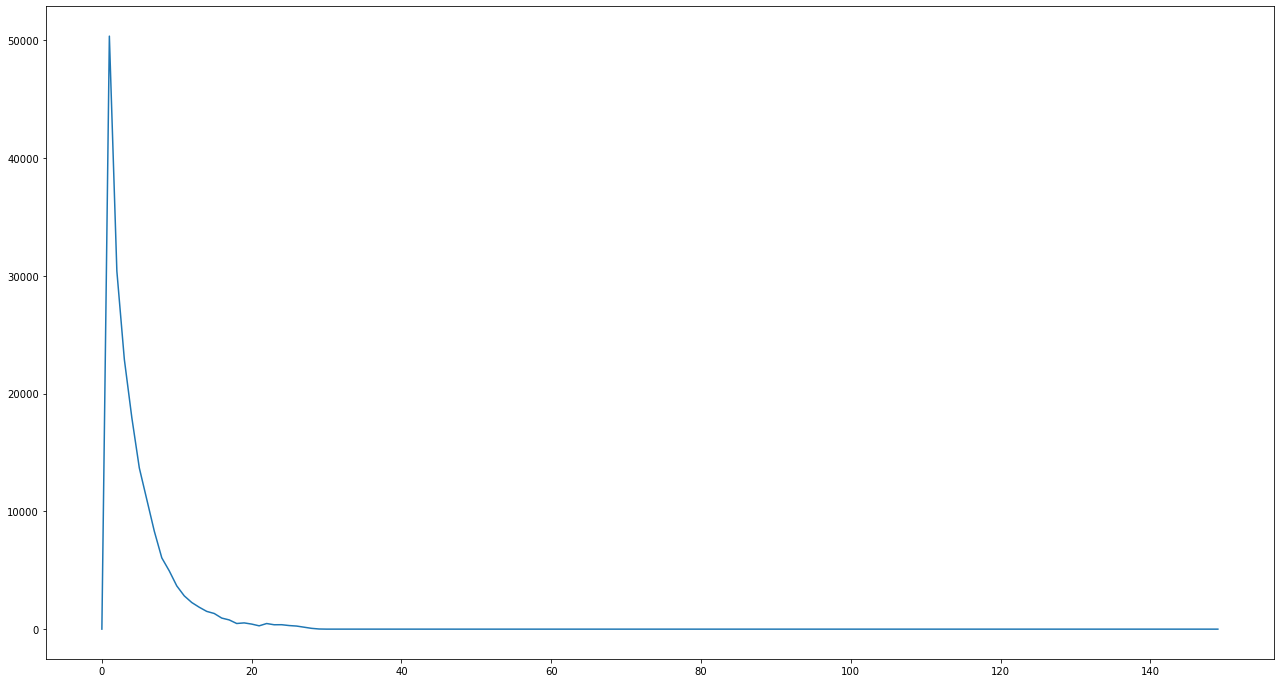

In [61]:
avg = 0
avgLossPerEpoch = []
for i in range(len(pltdata)):
    avg = avg + pltdata[i]
    if(i%780==0):
        avgLossPerEpoch.append(avg)
        avg = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch[0:150])       

learning rate  0.05
dev  cuda
[1,   100] loss: 0.0000025122
[1,   200] loss: 0.0000026256
[1,   300] loss: 0.0000024189
[1,   400] loss: 0.0000025519
[1,   500] loss: 0.0000023040
[1,   600] loss: 0.0000025401
[1,   700] loss: 0.0000027710
[2,   100] loss: 0.0000024281
[2,   200] loss: 0.0000025347
[2,   300] loss: 0.0000023352
[2,   400] loss: 0.0000024663
[2,   500] loss: 0.0000022263
[2,   600] loss: 0.0000024535
[2,   700] loss: 0.0000026747
[3,   100] loss: 0.0000023495
[3,   200] loss: 0.0000024493
[3,   300] loss: 0.0000022565
[3,   400] loss: 0.0000023871
[3,   500] loss: 0.0000021540
[3,   600] loss: 0.0000023735
[3,   700] loss: 0.0000025850
[4,   100] loss: 0.0000022756
[4,   200] loss: 0.0000023700
[4,   300] loss: 0.0000021836
[4,   400] loss: 0.0000023134
[4,   500] loss: 0.0000020862
[4,   600] loss: 0.0000022974
[4,   700] loss: 0.0000025016
[5,   100] loss: 0.0000022061
[5,   200] loss: 0.0000022964
[5,   300] loss: 0.0000021150
[5,   400] loss: 0.0000022438
[5,   500]

[39,   100] loss: 0.0000010992
[39,   200] loss: 0.0000011208
[39,   300] loss: 0.0000010336
[39,   400] loss: 0.0000011271
[39,   500] loss: 0.0000010079
[39,   600] loss: 0.0000011065
[39,   700] loss: 0.0000011928
[40,   100] loss: 0.0000010837
[40,   200] loss: 0.0000011042
[40,   300] loss: 0.0000010183
[40,   400] loss: 0.0000011114
[40,   500] loss: 0.0000009932
[40,   600] loss: 0.0000010909
[40,   700] loss: 0.0000011750
[41,   100] loss: 0.0000010683
[41,   200] loss: 0.0000010883
[41,   300] loss: 0.0000010033
[41,   400] loss: 0.0000010962
[41,   500] loss: 0.0000009797
[41,   600] loss: 0.0000010762
[41,   700] loss: 0.0000011584
[42,   100] loss: 0.0000010536
[42,   200] loss: 0.0000010728
[42,   300] loss: 0.0000009894
[42,   400] loss: 0.0000010809
[42,   500] loss: 0.0000009657
[42,   600] loss: 0.0000010607
[42,   700] loss: 0.0000011420
[43,   100] loss: 0.0000010394
[43,   200] loss: 0.0000010582
[43,   300] loss: 0.0000009753
[43,   400] loss: 0.0000010665
[43,   5

[76,   700] loss: 0.0000007743
[77,   100] loss: 0.0000007133
[77,   200] loss: 0.0000007182
[77,   300] loss: 0.0000006616
[77,   400] loss: 0.0000007330
[77,   500] loss: 0.0000006532
[77,   600] loss: 0.0000007153
[77,   700] loss: 0.0000007672
[78,   100] loss: 0.0000007066
[78,   200] loss: 0.0000007120
[78,   300] loss: 0.0000006553
[78,   400] loss: 0.0000007265
[78,   500] loss: 0.0000006472
[78,   600] loss: 0.0000007087
[78,   700] loss: 0.0000007598
[79,   100] loss: 0.0000007006
[79,   200] loss: 0.0000007052
[79,   300] loss: 0.0000006493
[79,   400] loss: 0.0000007200
[79,   500] loss: 0.0000006414
[79,   600] loss: 0.0000007027
[79,   700] loss: 0.0000007526
[80,   100] loss: 0.0000006941
[80,   200] loss: 0.0000006987
[80,   300] loss: 0.0000006434
[80,   400] loss: 0.0000007134
[80,   500] loss: 0.0000006358
[80,   600] loss: 0.0000006959
[80,   700] loss: 0.0000007457
[81,   100] loss: 0.0000006881
[81,   200] loss: 0.0000006923
[81,   300] loss: 0.0000006377
[81,   4

[114,   300] loss: 0.0000004916
[114,   400] loss: 0.0000005487
[114,   500] loss: 0.0000004881
[114,   600] loss: 0.0000005339
[114,   700] loss: 0.0000005703
[115,   100] loss: 0.0000005298
[115,   200] loss: 0.0000005296
[115,   300] loss: 0.0000004878
[115,   400] loss: 0.0000005450
[115,   500] loss: 0.0000004846
[115,   600] loss: 0.0000005304
[115,   700] loss: 0.0000005665
[116,   100] loss: 0.0000005263
[116,   200] loss: 0.0000005257
[116,   300] loss: 0.0000004847
[116,   400] loss: 0.0000005415
[116,   500] loss: 0.0000004813
[116,   600] loss: 0.0000005270
[116,   700] loss: 0.0000005623
[117,   100] loss: 0.0000005228
[117,   200] loss: 0.0000005229
[117,   300] loss: 0.0000004811
[117,   400] loss: 0.0000005375
[117,   500] loss: 0.0000004784
[117,   600] loss: 0.0000005232
[117,   700] loss: 0.0000005583
[118,   100] loss: 0.0000005193
[118,   200] loss: 0.0000005189
[118,   300] loss: 0.0000004780
[118,   400] loss: 0.0000005336
[118,   500] loss: 0.0000004752
[118,   

Finished Training on GPU
Accuracy of plane : 89.09 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 78.48 %
Accuracy of   cat : 64.38 %
Accuracy of  deer : 80.00 %
Accuracy of   dog : 79.31 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 84.62 %
Accuracy of the network on the 9984 test images: 83.80 %


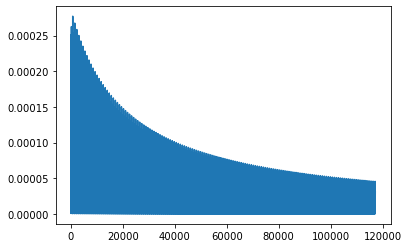

In [12]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.05)
pltdata1 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata1)

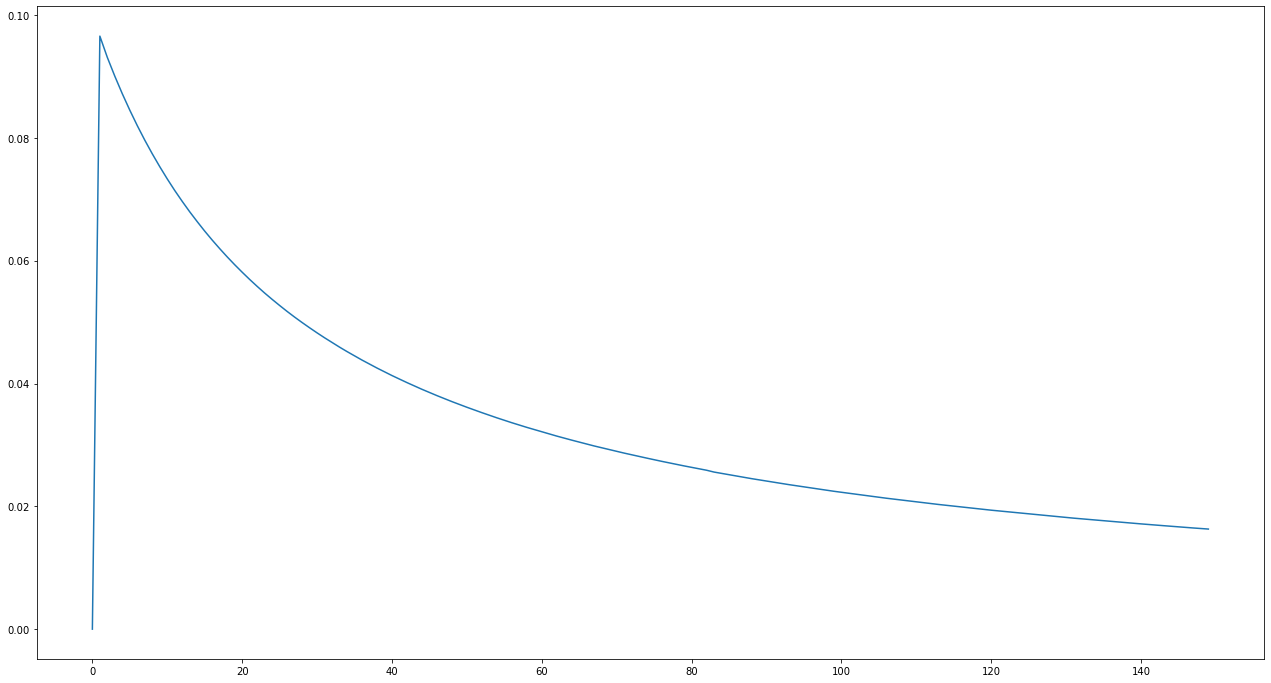

In [62]:
avg1 = 0
avgLossPerEpoch1 = []
for i in range(len(pltdata1)):
    avg1 = avg1 + pltdata1[i]
    if(i%780==0):
        avgLossPerEpoch1.append(avg1)
        avg1 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch1[0:150])       

learning rate  0.02
dev  cuda
[1,   100] loss: 0.0000004271
[1,   200] loss: 0.0000004247
[1,   300] loss: 0.0000003910
[1,   400] loss: 0.0000004392
[1,   500] loss: 0.0000003909
[1,   600] loss: 0.0000004273
[1,   700] loss: 0.0000004552
[2,   100] loss: 0.0000004262
[2,   200] loss: 0.0000004239
[2,   300] loss: 0.0000003903
[2,   400] loss: 0.0000004384
[2,   500] loss: 0.0000003901
[2,   600] loss: 0.0000004263
[2,   700] loss: 0.0000004541
[3,   100] loss: 0.0000004254
[3,   200] loss: 0.0000004228
[3,   300] loss: 0.0000003894
[3,   400] loss: 0.0000004376
[3,   500] loss: 0.0000003893
[3,   600] loss: 0.0000004252
[3,   700] loss: 0.0000004535
[4,   100] loss: 0.0000004246
[4,   200] loss: 0.0000004221
[4,   300] loss: 0.0000003888
[4,   400] loss: 0.0000004368
[4,   500] loss: 0.0000003888
[4,   600] loss: 0.0000004245
[4,   700] loss: 0.0000004526
[5,   100] loss: 0.0000004239
[5,   200] loss: 0.0000004212
[5,   300] loss: 0.0000003880
[5,   400] loss: 0.0000004357
[5,   500]

[39,   100] loss: 0.0000003980
[39,   200] loss: 0.0000003955
[39,   300] loss: 0.0000003642
[39,   400] loss: 0.0000004099
[39,   500] loss: 0.0000003645
[39,   600] loss: 0.0000003977
[39,   700] loss: 0.0000004235
[40,   100] loss: 0.0000003972
[40,   200] loss: 0.0000003947
[40,   300] loss: 0.0000003637
[40,   400] loss: 0.0000004091
[40,   500] loss: 0.0000003638
[40,   600] loss: 0.0000003970
[40,   700] loss: 0.0000004227
[41,   100] loss: 0.0000003966
[41,   200] loss: 0.0000003940
[41,   300] loss: 0.0000003629
[41,   400] loss: 0.0000004082
[41,   500] loss: 0.0000003632
[41,   600] loss: 0.0000003965
[41,   700] loss: 0.0000004220
[42,   100] loss: 0.0000003959
[42,   200] loss: 0.0000003934
[42,   300] loss: 0.0000003623
[42,   400] loss: 0.0000004074
[42,   500] loss: 0.0000003625
[42,   600] loss: 0.0000003959
[42,   700] loss: 0.0000004214
[43,   100] loss: 0.0000003952
[43,   200] loss: 0.0000003926
[43,   300] loss: 0.0000003616
[43,   400] loss: 0.0000004070
[43,   5

[76,   700] loss: 0.0000003974
[77,   100] loss: 0.0000003735
[77,   200] loss: 0.0000003706
[77,   300] loss: 0.0000003412
[77,   400] loss: 0.0000003843
[77,   500] loss: 0.0000003417
[77,   600] loss: 0.0000003731
[77,   700] loss: 0.0000003969
[78,   100] loss: 0.0000003729
[78,   200] loss: 0.0000003698
[78,   300] loss: 0.0000003407
[78,   400] loss: 0.0000003837
[78,   500] loss: 0.0000003411
[78,   600] loss: 0.0000003726
[78,   700] loss: 0.0000003963
[79,   100] loss: 0.0000003723
[79,   200] loss: 0.0000003693
[79,   300] loss: 0.0000003404
[79,   400] loss: 0.0000003831
[79,   500] loss: 0.0000003407
[79,   600] loss: 0.0000003720
[79,   700] loss: 0.0000003955
[80,   100] loss: 0.0000003716
[80,   200] loss: 0.0000003687
[80,   300] loss: 0.0000003398
[80,   400] loss: 0.0000003825
[80,   500] loss: 0.0000003401
[80,   600] loss: 0.0000003714
[80,   700] loss: 0.0000003948
[81,   100] loss: 0.0000003707
[81,   200] loss: 0.0000003680
[81,   300] loss: 0.0000003392
[81,   4

[114,   300] loss: 0.0000003219
[114,   400] loss: 0.0000003632
[114,   500] loss: 0.0000003226
[114,   600] loss: 0.0000003520
[114,   700] loss: 0.0000003744
[115,   100] loss: 0.0000003519
[115,   200] loss: 0.0000003487
[115,   300] loss: 0.0000003213
[115,   400] loss: 0.0000003627
[115,   500] loss: 0.0000003221
[115,   600] loss: 0.0000003515
[115,   700] loss: 0.0000003737
[116,   100] loss: 0.0000003513
[116,   200] loss: 0.0000003480
[116,   300] loss: 0.0000003206
[116,   400] loss: 0.0000003621
[116,   500] loss: 0.0000003217
[116,   600] loss: 0.0000003510
[116,   700] loss: 0.0000003731
[117,   100] loss: 0.0000003509
[117,   200] loss: 0.0000003475
[117,   300] loss: 0.0000003202
[117,   400] loss: 0.0000003616
[117,   500] loss: 0.0000003212
[117,   600] loss: 0.0000003506
[117,   700] loss: 0.0000003725
[118,   100] loss: 0.0000003504
[118,   200] loss: 0.0000003471
[118,   300] loss: 0.0000003198
[118,   400] loss: 0.0000003609
[118,   500] loss: 0.0000003210
[118,   

Finished Training on GPU
Accuracy of plane : 89.09 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 78.48 %
Accuracy of   cat : 64.38 %
Accuracy of  deer : 80.00 %
Accuracy of   dog : 79.31 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 84.62 %
Accuracy of the network on the 9984 test images: 83.80 %


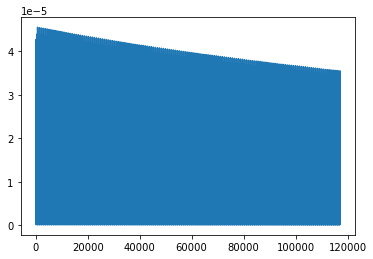

In [13]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.02)
pltdata2 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata2)

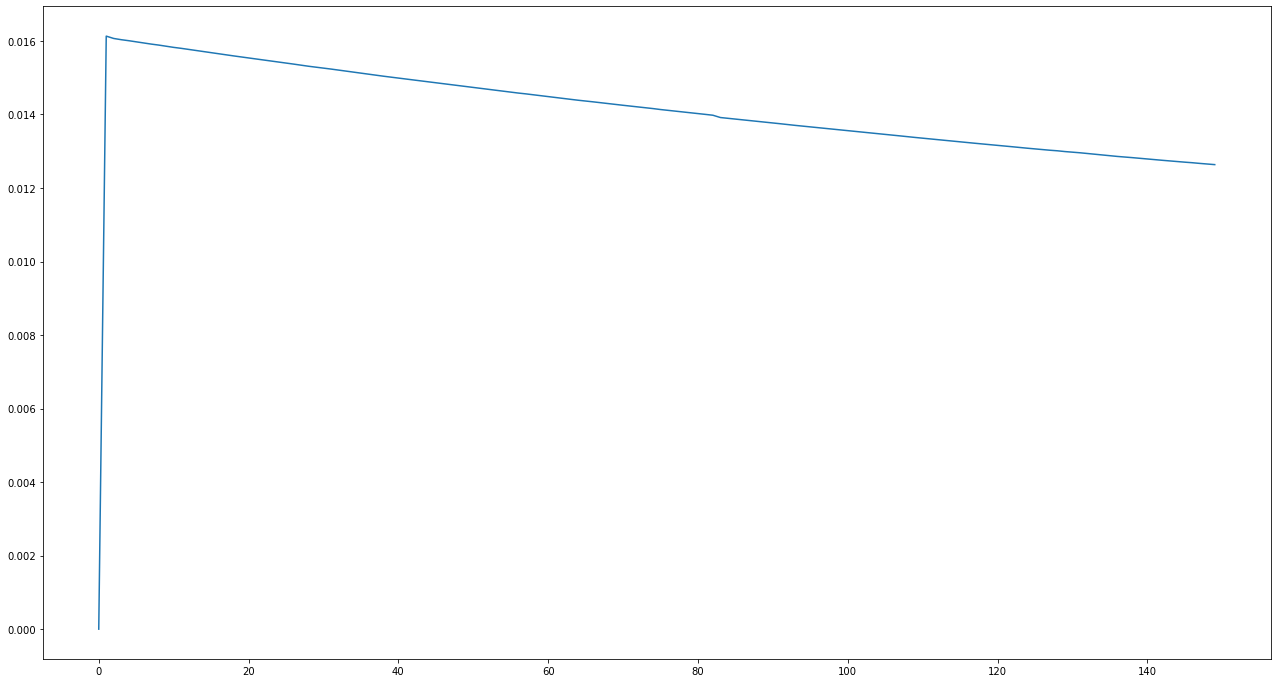

In [63]:
avg2 = 0
avgLossPerEpoch2 = []
for i in range(len(pltdata2)):
    avg2 = avg2 + pltdata2[i]
    if(i%780==0):
        avgLossPerEpoch2.append(avg2)
        avg2 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch2[0:150])       

learning rate  0.03
dev  cuda
[1,   100] loss: 0.0000003342
[1,   200] loss: 0.0000003310
[1,   300] loss: 0.0000003052
[1,   400] loss: 0.0000003447
[1,   500] loss: 0.0000003057
[1,   600] loss: 0.0000003337
[1,   700] loss: 0.0000003543
[2,   100] loss: 0.0000003333
[2,   200] loss: 0.0000003302
[2,   300] loss: 0.0000003044
[2,   400] loss: 0.0000003437
[2,   500] loss: 0.0000003048
[2,   600] loss: 0.0000003329
[2,   700] loss: 0.0000003536
[3,   100] loss: 0.0000003328
[3,   200] loss: 0.0000003294
[3,   300] loss: 0.0000003039
[3,   400] loss: 0.0000003429
[3,   500] loss: 0.0000003042
[3,   600] loss: 0.0000003323
[3,   700] loss: 0.0000003528
[4,   100] loss: 0.0000003321
[4,   200] loss: 0.0000003287
[4,   300] loss: 0.0000003031
[4,   400] loss: 0.0000003421
[4,   500] loss: 0.0000003035
[4,   600] loss: 0.0000003315
[4,   700] loss: 0.0000003520
[5,   100] loss: 0.0000003310
[5,   200] loss: 0.0000003278
[5,   300] loss: 0.0000003025
[5,   400] loss: 0.0000003410
[5,   500]

[39,   100] loss: 0.0000003073
[39,   200] loss: 0.0000003039
[39,   300] loss: 0.0000002798
[39,   400] loss: 0.0000003166
[39,   500] loss: 0.0000002813
[39,   600] loss: 0.0000003065
[39,   700] loss: 0.0000003250
[40,   100] loss: 0.0000003068
[40,   200] loss: 0.0000003033
[40,   300] loss: 0.0000002792
[40,   400] loss: 0.0000003160
[40,   500] loss: 0.0000002807
[40,   600] loss: 0.0000003058
[40,   700] loss: 0.0000003243
[41,   100] loss: 0.0000003062
[41,   200] loss: 0.0000003024
[41,   300] loss: 0.0000002786
[41,   400] loss: 0.0000003156
[41,   500] loss: 0.0000002802
[41,   600] loss: 0.0000003051
[41,   700] loss: 0.0000003236
[42,   100] loss: 0.0000003055
[42,   200] loss: 0.0000003017
[42,   300] loss: 0.0000002780
[42,   400] loss: 0.0000003149
[42,   500] loss: 0.0000002797
[42,   600] loss: 0.0000003044
[42,   700] loss: 0.0000003227
[43,   100] loss: 0.0000003047
[43,   200] loss: 0.0000003012
[43,   300] loss: 0.0000002774
[43,   400] loss: 0.0000003142
[43,   5

[76,   700] loss: 0.0000003015
[77,   100] loss: 0.0000002849
[77,   200] loss: 0.0000002814
[77,   300] loss: 0.0000002591
[77,   400] loss: 0.0000002931
[77,   500] loss: 0.0000002608
[77,   600] loss: 0.0000002839
[77,   700] loss: 0.0000003008
[78,   100] loss: 0.0000002844
[78,   200] loss: 0.0000002811
[78,   300] loss: 0.0000002585
[78,   400] loss: 0.0000002927
[78,   500] loss: 0.0000002602
[78,   600] loss: 0.0000002833
[78,   700] loss: 0.0000003002
[79,   100] loss: 0.0000002838
[79,   200] loss: 0.0000002804
[79,   300] loss: 0.0000002580
[79,   400] loss: 0.0000002921
[79,   500] loss: 0.0000002597
[79,   600] loss: 0.0000002827
[79,   700] loss: 0.0000002997
[80,   100] loss: 0.0000002830
[80,   200] loss: 0.0000002798
[80,   300] loss: 0.0000002576
[80,   400] loss: 0.0000002917
[80,   500] loss: 0.0000002594
[80,   600] loss: 0.0000002822
[80,   700] loss: 0.0000002992
[81,   100] loss: 0.0000002825
[81,   200] loss: 0.0000002792
[81,   300] loss: 0.0000002572
[81,   4

[114,   300] loss: 0.0000002416
[114,   400] loss: 0.0000002747
[114,   500] loss: 0.0000002436
[114,   600] loss: 0.0000002650
[114,   700] loss: 0.0000002808
[115,   100] loss: 0.0000002658
[115,   200] loss: 0.0000002620
[115,   300] loss: 0.0000002411
[115,   400] loss: 0.0000002742
[115,   500] loss: 0.0000002432
[115,   600] loss: 0.0000002645
[115,   700] loss: 0.0000002802
[116,   100] loss: 0.0000002652
[116,   200] loss: 0.0000002615
[116,   300] loss: 0.0000002406
[116,   400] loss: 0.0000002737
[116,   500] loss: 0.0000002428
[116,   600] loss: 0.0000002640
[116,   700] loss: 0.0000002797
[117,   100] loss: 0.0000002649
[117,   200] loss: 0.0000002610
[117,   300] loss: 0.0000002402
[117,   400] loss: 0.0000002731
[117,   500] loss: 0.0000002424
[117,   600] loss: 0.0000002636
[117,   700] loss: 0.0000002791
[118,   100] loss: 0.0000002644
[118,   200] loss: 0.0000002606
[118,   300] loss: 0.0000002398
[118,   400] loss: 0.0000002726
[118,   500] loss: 0.0000002420
[118,   

Finished Training on GPU
Accuracy of plane : 89.09 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 78.48 %
Accuracy of   cat : 65.75 %
Accuracy of  deer : 80.00 %
Accuracy of   dog : 79.31 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 83.33 %
Accuracy of the network on the 9984 test images: 83.84 %


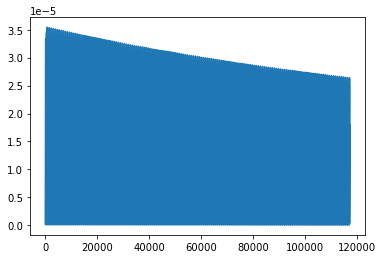

In [14]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.03)
pltdata3 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata3)

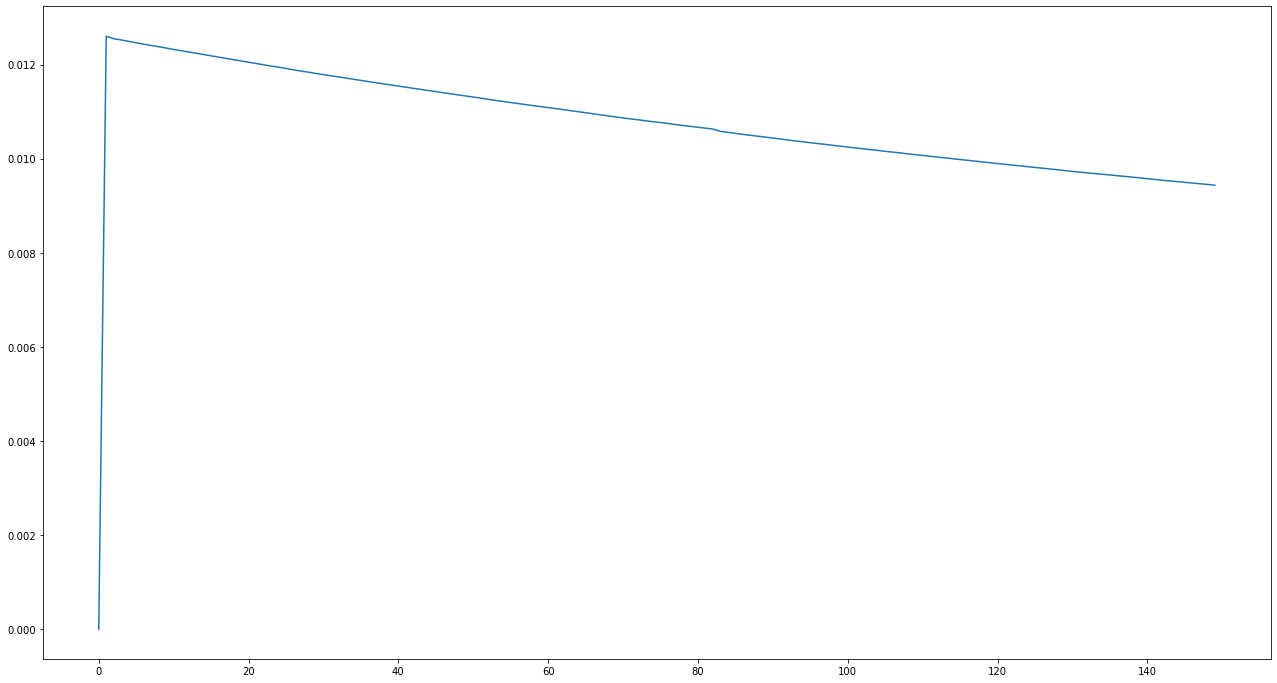

In [67]:
avg3 = 0
avgLossPerEpoch3 = []
for i in range(len(pltdata3)):
    avg3 = avg3 + pltdata3[i]
    if(i%780==0):
        avgLossPerEpoch3.append(avg3)
        avg3 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch3[0:150])       

learning rate  0.04
dev  cuda
[1,   100] loss: 0.0000002505
[1,   200] loss: 0.0000002456
[1,   300] loss: 0.0000002271
[1,   400] loss: 0.0000002578
[1,   500] loss: 0.0000002287
[1,   600] loss: 0.0000002490
[1,   700] loss: 0.0000002635
[2,   100] loss: 0.0000002497
[2,   200] loss: 0.0000002452
[2,   300] loss: 0.0000002265
[2,   400] loss: 0.0000002572
[2,   500] loss: 0.0000002283
[2,   600] loss: 0.0000002483
[2,   700] loss: 0.0000002630
[3,   100] loss: 0.0000002492
[3,   200] loss: 0.0000002447
[3,   300] loss: 0.0000002260
[3,   400] loss: 0.0000002567
[3,   500] loss: 0.0000002278
[3,   600] loss: 0.0000002477
[3,   700] loss: 0.0000002625
[4,   100] loss: 0.0000002487
[4,   200] loss: 0.0000002442
[4,   300] loss: 0.0000002255
[4,   400] loss: 0.0000002562
[4,   500] loss: 0.0000002271
[4,   600] loss: 0.0000002471
[4,   700] loss: 0.0000002618
[5,   100] loss: 0.0000002481
[5,   200] loss: 0.0000002436
[5,   300] loss: 0.0000002250
[5,   400] loss: 0.0000002556
[5,   500]

[39,   100] loss: 0.0000002298
[39,   200] loss: 0.0000002257
[39,   300] loss: 0.0000002088
[39,   400] loss: 0.0000002369
[39,   500] loss: 0.0000002102
[39,   600] loss: 0.0000002285
[39,   700] loss: 0.0000002417
[40,   100] loss: 0.0000002293
[40,   200] loss: 0.0000002253
[40,   300] loss: 0.0000002084
[40,   400] loss: 0.0000002363
[40,   500] loss: 0.0000002098
[40,   600] loss: 0.0000002282
[40,   700] loss: 0.0000002412
[41,   100] loss: 0.0000002287
[41,   200] loss: 0.0000002248
[41,   300] loss: 0.0000002079
[41,   400] loss: 0.0000002358
[41,   500] loss: 0.0000002093
[41,   600] loss: 0.0000002275
[41,   700] loss: 0.0000002405
[42,   100] loss: 0.0000002283
[42,   200] loss: 0.0000002243
[42,   300] loss: 0.0000002075
[42,   400] loss: 0.0000002353
[42,   500] loss: 0.0000002088
[42,   600] loss: 0.0000002270
[42,   700] loss: 0.0000002401
[43,   100] loss: 0.0000002278
[43,   200] loss: 0.0000002238
[43,   300] loss: 0.0000002071
[43,   400] loss: 0.0000002349
[43,   5

[76,   700] loss: 0.0000002241
[77,   100] loss: 0.0000002126
[77,   200] loss: 0.0000002090
[77,   300] loss: 0.0000001934
[77,   400] loss: 0.0000002194
[77,   500] loss: 0.0000001945
[77,   600] loss: 0.0000002119
[77,   700] loss: 0.0000002237
[78,   100] loss: 0.0000002121
[78,   200] loss: 0.0000002086
[78,   300] loss: 0.0000001930
[78,   400] loss: 0.0000002190
[78,   500] loss: 0.0000001942
[78,   600] loss: 0.0000002114
[78,   700] loss: 0.0000002233
[79,   100] loss: 0.0000002117
[79,   200] loss: 0.0000002083
[79,   300] loss: 0.0000001925
[79,   400] loss: 0.0000002185
[79,   500] loss: 0.0000001938
[79,   600] loss: 0.0000002109
[79,   700] loss: 0.0000002230
[80,   100] loss: 0.0000002114
[80,   200] loss: 0.0000002078
[80,   300] loss: 0.0000001920
[80,   400] loss: 0.0000002180
[80,   500] loss: 0.0000001935
[80,   600] loss: 0.0000002106
[80,   700] loss: 0.0000002224
[81,   100] loss: 0.0000002110
[81,   200] loss: 0.0000002074
[81,   300] loss: 0.0000001916
[81,   4

[114,   300] loss: 0.0000001806
[114,   400] loss: 0.0000002050
[114,   500] loss: 0.0000001821
[114,   600] loss: 0.0000001979
[114,   700] loss: 0.0000002090
[115,   100] loss: 0.0000001984
[115,   200] loss: 0.0000001949
[115,   300] loss: 0.0000001802
[115,   400] loss: 0.0000002046
[115,   500] loss: 0.0000001818
[115,   600] loss: 0.0000001976
[115,   700] loss: 0.0000002086
[116,   100] loss: 0.0000001980
[116,   200] loss: 0.0000001947
[116,   300] loss: 0.0000001799
[116,   400] loss: 0.0000002044
[116,   500] loss: 0.0000001814
[116,   600] loss: 0.0000001971
[116,   700] loss: 0.0000002082
[117,   100] loss: 0.0000001977
[117,   200] loss: 0.0000001943
[117,   300] loss: 0.0000001797
[117,   400] loss: 0.0000002040
[117,   500] loss: 0.0000001810
[117,   600] loss: 0.0000001968
[117,   700] loss: 0.0000002078
[118,   100] loss: 0.0000001974
[118,   200] loss: 0.0000001940
[118,   300] loss: 0.0000001794
[118,   400] loss: 0.0000002036
[118,   500] loss: 0.0000001805
[118,   

Finished Training on GPU
Accuracy of plane : 89.09 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 78.48 %
Accuracy of   cat : 65.75 %
Accuracy of  deer : 81.82 %
Accuracy of   dog : 79.31 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 83.33 %
Accuracy of the network on the 9984 test images: 83.87 %


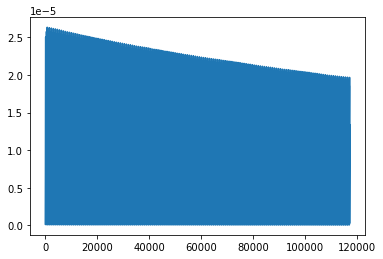

In [15]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.04)
pltdata4 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata4)

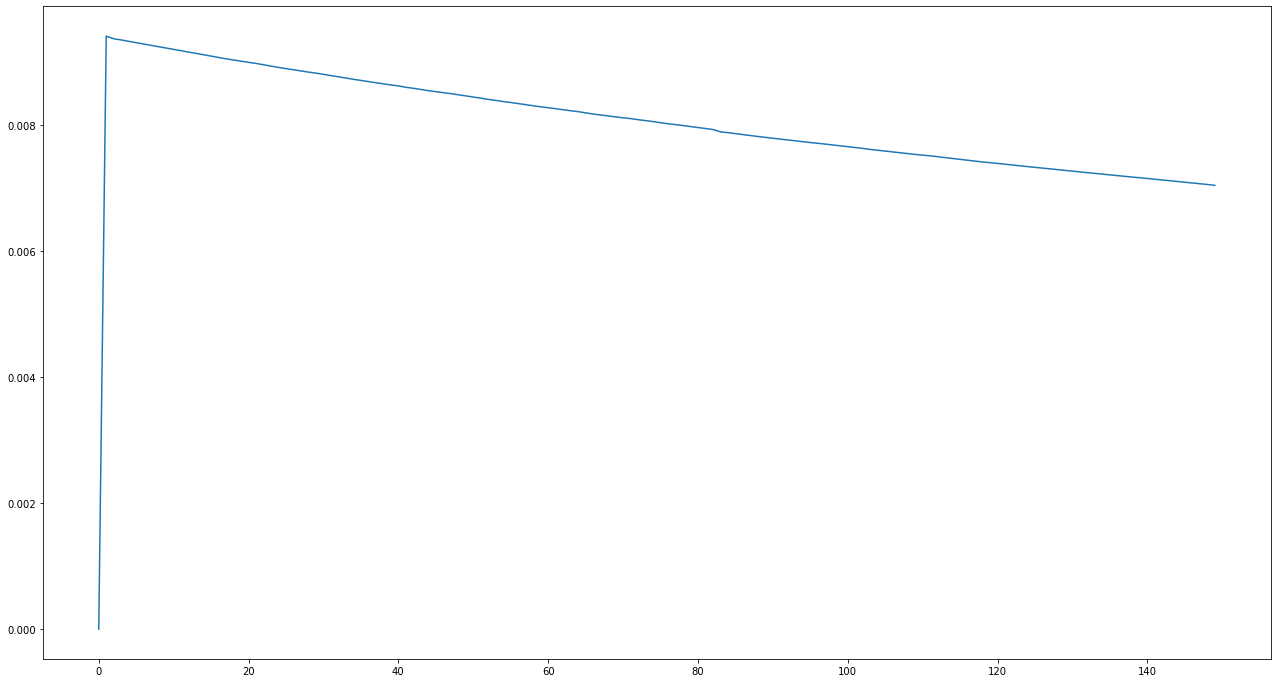

In [68]:
avg4 = 0
avgLossPerEpoch4 = []
for i in range(len(pltdata4)):
    avg4 = avg4 + pltdata4[i]
    if(i%780==0):
        avgLossPerEpoch4.append(avg4)
        avg4 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch4[0:150])       

learning rate  0.05
dev  cuda
[1,   100] loss: 0.0000001867
[1,   200] loss: 0.0000001832
[1,   300] loss: 0.0000001695
[1,   400] loss: 0.0000001926
[1,   500] loss: 0.0000001707
[1,   600] loss: 0.0000001853
[1,   700] loss: 0.0000001965
[2,   100] loss: 0.0000001863
[2,   200] loss: 0.0000001828
[2,   300] loss: 0.0000001691
[2,   400] loss: 0.0000001922
[2,   500] loss: 0.0000001703
[2,   600] loss: 0.0000001850
[2,   700] loss: 0.0000001961
[3,   100] loss: 0.0000001859
[3,   200] loss: 0.0000001824
[3,   300] loss: 0.0000001688
[3,   400] loss: 0.0000001919
[3,   500] loss: 0.0000001699
[3,   600] loss: 0.0000001846
[3,   700] loss: 0.0000001956
[4,   100] loss: 0.0000001855
[4,   200] loss: 0.0000001821
[4,   300] loss: 0.0000001683
[4,   400] loss: 0.0000001915
[4,   500] loss: 0.0000001696
[4,   600] loss: 0.0000001843
[4,   700] loss: 0.0000001952
[5,   100] loss: 0.0000001850
[5,   200] loss: 0.0000001816
[5,   300] loss: 0.0000001679
[5,   400] loss: 0.0000001912
[5,   500]

[39,   100] loss: 0.0000001727
[39,   200] loss: 0.0000001691
[39,   300] loss: 0.0000001565
[39,   400] loss: 0.0000001781
[39,   500] loss: 0.0000001579
[39,   600] loss: 0.0000001712
[39,   700] loss: 0.0000001812
[40,   100] loss: 0.0000001723
[40,   200] loss: 0.0000001688
[40,   300] loss: 0.0000001562
[40,   400] loss: 0.0000001777
[40,   500] loss: 0.0000001577
[40,   600] loss: 0.0000001708
[40,   700] loss: 0.0000001808
[41,   100] loss: 0.0000001720
[41,   200] loss: 0.0000001684
[41,   300] loss: 0.0000001558
[41,   400] loss: 0.0000001773
[41,   500] loss: 0.0000001574
[41,   600] loss: 0.0000001705
[41,   700] loss: 0.0000001805
[42,   100] loss: 0.0000001716
[42,   200] loss: 0.0000001680
[42,   300] loss: 0.0000001553
[42,   400] loss: 0.0000001770
[42,   500] loss: 0.0000001572
[42,   600] loss: 0.0000001700
[42,   700] loss: 0.0000001802
[43,   100] loss: 0.0000001714
[43,   200] loss: 0.0000001677
[43,   300] loss: 0.0000001551
[43,   400] loss: 0.0000001766
[43,   5

[76,   700] loss: 0.0000001688
[77,   100] loss: 0.0000001610
[77,   200] loss: 0.0000001575
[77,   300] loss: 0.0000001457
[77,   400] loss: 0.0000001665
[77,   500] loss: 0.0000001474
[77,   600] loss: 0.0000001598
[77,   700] loss: 0.0000001685
[78,   100] loss: 0.0000001608
[78,   200] loss: 0.0000001572
[78,   300] loss: 0.0000001454
[78,   400] loss: 0.0000001662
[78,   500] loss: 0.0000001471
[78,   600] loss: 0.0000001596
[78,   700] loss: 0.0000001681
[79,   100] loss: 0.0000001605
[79,   200] loss: 0.0000001570
[79,   300] loss: 0.0000001450
[79,   400] loss: 0.0000001659
[79,   500] loss: 0.0000001467
[79,   600] loss: 0.0000001593
[79,   700] loss: 0.0000001678
[80,   100] loss: 0.0000001602
[80,   200] loss: 0.0000001565
[80,   300] loss: 0.0000001448
[80,   400] loss: 0.0000001656
[80,   500] loss: 0.0000001464
[80,   600] loss: 0.0000001590
[80,   700] loss: 0.0000001676
[81,   100] loss: 0.0000001597
[81,   200] loss: 0.0000001562
[81,   300] loss: 0.0000001445
[81,   4

[114,   300] loss: 0.0000001363
[114,   400] loss: 0.0000001562
[114,   500] loss: 0.0000001385
[114,   600] loss: 0.0000001499
[114,   700] loss: 0.0000001581
[115,   100] loss: 0.0000001511
[115,   200] loss: 0.0000001476
[115,   300] loss: 0.0000001359
[115,   400] loss: 0.0000001558
[115,   500] loss: 0.0000001383
[115,   600] loss: 0.0000001498
[115,   700] loss: 0.0000001579
[116,   100] loss: 0.0000001509
[116,   200] loss: 0.0000001473
[116,   300] loss: 0.0000001357
[116,   400] loss: 0.0000001555
[116,   500] loss: 0.0000001380
[116,   600] loss: 0.0000001495
[116,   700] loss: 0.0000001576
[117,   100] loss: 0.0000001507
[117,   200] loss: 0.0000001470
[117,   300] loss: 0.0000001354
[117,   400] loss: 0.0000001553
[117,   500] loss: 0.0000001378
[117,   600] loss: 0.0000001494
[117,   700] loss: 0.0000001573
[118,   100] loss: 0.0000001504
[118,   200] loss: 0.0000001468
[118,   300] loss: 0.0000001352
[118,   400] loss: 0.0000001549
[118,   500] loss: 0.0000001375
[118,   

Finished Training on GPU
Accuracy of plane : 89.09 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 78.48 %
Accuracy of   cat : 65.75 %
Accuracy of  deer : 81.82 %
Accuracy of   dog : 79.31 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 83.33 %
Accuracy of the network on the 9984 test images: 83.90 %


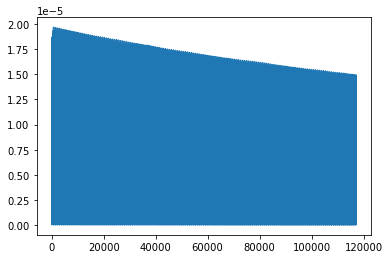

In [16]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.05)
pltdata5 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata5)

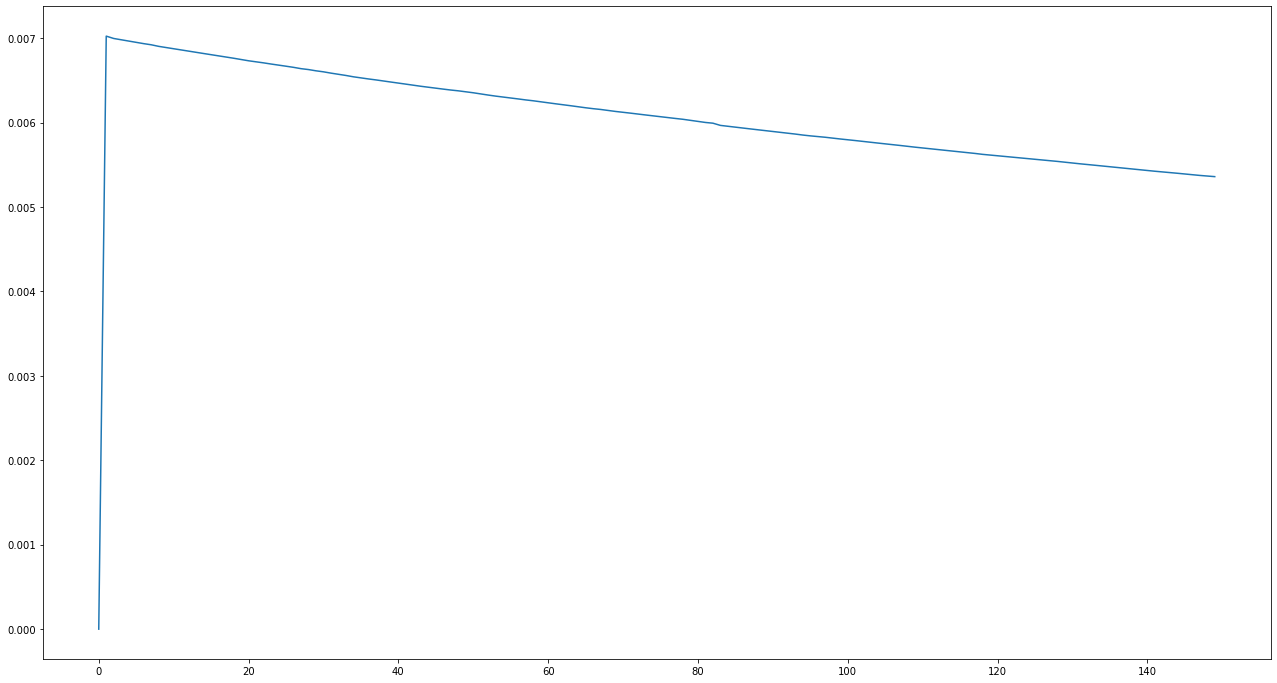

In [69]:
avg5 = 0
avgLossPerEpoch5 = []
for i in range(len(pltdata5)):
    avg5 = avg5 + pltdata5[i]
    if(i%780==0):
        avgLossPerEpoch5.append(avg5)
        avg5 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch5[0:150])       

learning rate  0.06
dev  cuda
[1,   100] loss: 0.0000001432
[1,   200] loss: 0.0000001395
[1,   300] loss: 0.0000001281
[1,   400] loss: 0.0000001471
[1,   500] loss: 0.0000001304
[1,   600] loss: 0.0000001410
[1,   700] loss: 0.0000001489
[2,   100] loss: 0.0000001429
[2,   200] loss: 0.0000001392
[2,   300] loss: 0.0000001279
[2,   400] loss: 0.0000001469
[2,   500] loss: 0.0000001301
[2,   600] loss: 0.0000001406
[2,   700] loss: 0.0000001487
[3,   100] loss: 0.0000001427
[3,   200] loss: 0.0000001388
[3,   300] loss: 0.0000001278
[3,   400] loss: 0.0000001465
[3,   500] loss: 0.0000001299
[3,   600] loss: 0.0000001404
[3,   700] loss: 0.0000001484
[4,   100] loss: 0.0000001425
[4,   200] loss: 0.0000001386
[4,   300] loss: 0.0000001275
[4,   400] loss: 0.0000001462
[4,   500] loss: 0.0000001297
[4,   600] loss: 0.0000001401
[4,   700] loss: 0.0000001482
[5,   100] loss: 0.0000001421
[5,   200] loss: 0.0000001383
[5,   300] loss: 0.0000001273
[5,   400] loss: 0.0000001459
[5,   500]

[39,   100] loss: 0.0000001332
[39,   200] loss: 0.0000001298
[39,   300] loss: 0.0000001193
[39,   400] loss: 0.0000001374
[39,   500] loss: 0.0000001215
[39,   600] loss: 0.0000001315
[39,   700] loss: 0.0000001384
[40,   100] loss: 0.0000001329
[40,   200] loss: 0.0000001297
[40,   300] loss: 0.0000001190
[40,   400] loss: 0.0000001371
[40,   500] loss: 0.0000001213
[40,   600] loss: 0.0000001313
[40,   700] loss: 0.0000001382
[41,   100] loss: 0.0000001327
[41,   200] loss: 0.0000001295
[41,   300] loss: 0.0000001188
[41,   400] loss: 0.0000001370
[41,   500] loss: 0.0000001211
[41,   600] loss: 0.0000001311
[41,   700] loss: 0.0000001379
[42,   100] loss: 0.0000001325
[42,   200] loss: 0.0000001292
[42,   300] loss: 0.0000001186
[42,   400] loss: 0.0000001368
[42,   500] loss: 0.0000001210
[42,   600] loss: 0.0000001309
[42,   700] loss: 0.0000001376
[43,   100] loss: 0.0000001323
[43,   200] loss: 0.0000001290
[43,   300] loss: 0.0000001184
[43,   400] loss: 0.0000001365
[43,   5

[76,   700] loss: 0.0000001300
[77,   100] loss: 0.0000001252
[77,   200] loss: 0.0000001215
[77,   300] loss: 0.0000001121
[77,   400] loss: 0.0000001287
[77,   500] loss: 0.0000001138
[77,   600] loss: 0.0000001231
[77,   700] loss: 0.0000001298
[78,   100] loss: 0.0000001249
[78,   200] loss: 0.0000001214
[78,   300] loss: 0.0000001118
[78,   400] loss: 0.0000001285
[78,   500] loss: 0.0000001137
[78,   600] loss: 0.0000001229
[78,   700] loss: 0.0000001295
[79,   100] loss: 0.0000001247
[79,   200] loss: 0.0000001211
[79,   300] loss: 0.0000001116
[79,   400] loss: 0.0000001284
[79,   500] loss: 0.0000001136
[79,   600] loss: 0.0000001226
[79,   700] loss: 0.0000001294
[80,   100] loss: 0.0000001246
[80,   200] loss: 0.0000001210
[80,   300] loss: 0.0000001114
[80,   400] loss: 0.0000001281
[80,   500] loss: 0.0000001134
[80,   600] loss: 0.0000001225
[80,   700] loss: 0.0000001291
[81,   100] loss: 0.0000001242
[81,   200] loss: 0.0000001208
[81,   300] loss: 0.0000001112
[81,   4

[114,   300] loss: 0.0000001057
[114,   400] loss: 0.0000001212
[114,   500] loss: 0.0000001073
[114,   600] loss: 0.0000001162
[114,   700] loss: 0.0000001224
[115,   100] loss: 0.0000001177
[115,   200] loss: 0.0000001146
[115,   300] loss: 0.0000001056
[115,   400] loss: 0.0000001211
[115,   500] loss: 0.0000001071
[115,   600] loss: 0.0000001160
[115,   700] loss: 0.0000001222
[116,   100] loss: 0.0000001176
[116,   200] loss: 0.0000001145
[116,   300] loss: 0.0000001054
[116,   400] loss: 0.0000001210
[116,   500] loss: 0.0000001069
[116,   600] loss: 0.0000001159
[116,   700] loss: 0.0000001219
[117,   100] loss: 0.0000001174
[117,   200] loss: 0.0000001144
[117,   300] loss: 0.0000001051
[117,   400] loss: 0.0000001208
[117,   500] loss: 0.0000001067
[117,   600] loss: 0.0000001157
[117,   700] loss: 0.0000001218
[118,   100] loss: 0.0000001172
[118,   200] loss: 0.0000001143
[118,   300] loss: 0.0000001049
[118,   400] loss: 0.0000001207
[118,   500] loss: 0.0000001066
[118,   

Finished Training on GPU
Accuracy of plane : 89.09 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 78.48 %
Accuracy of   cat : 64.38 %
Accuracy of  deer : 81.82 %
Accuracy of   dog : 79.31 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 83.33 %
Accuracy of the network on the 9984 test images: 83.90 %


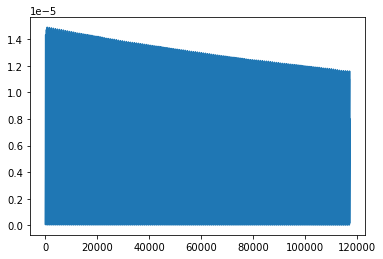

In [17]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.06)
pltdata6 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata6)

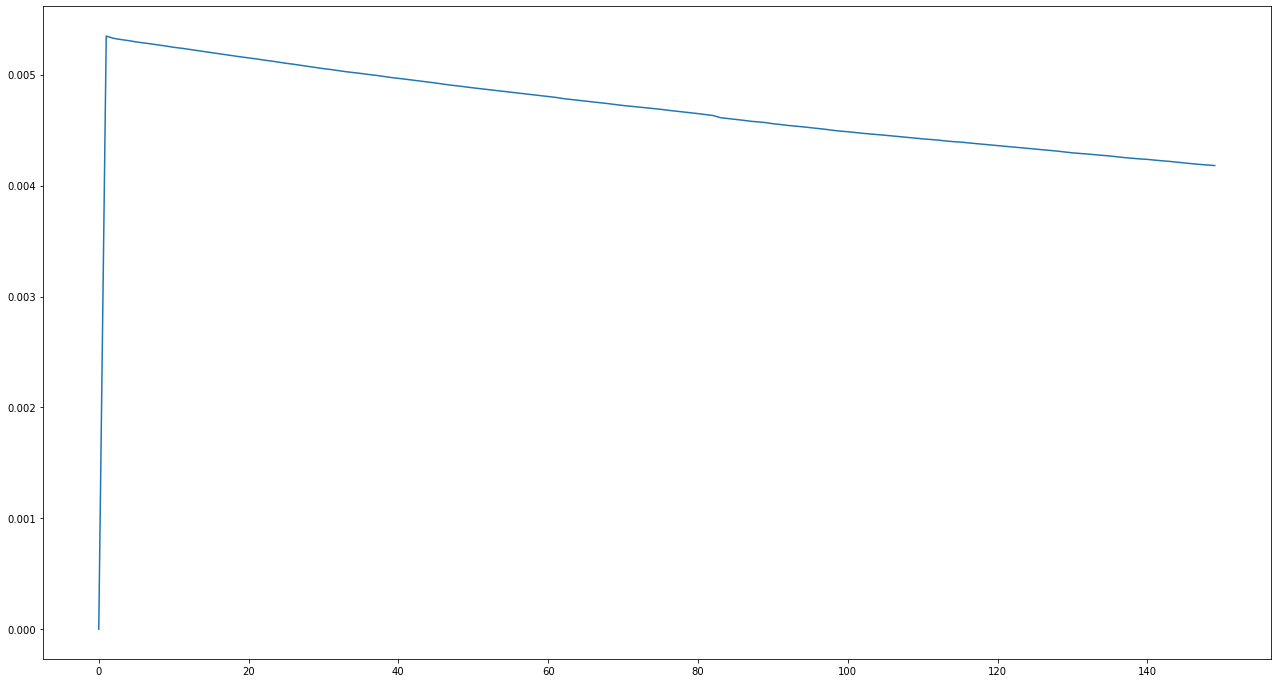

In [71]:
avg6 = 0
avgLossPerEpoch6 = []
for i in range(len(pltdata6)):
    avg6 = avg6 + pltdata6[i]
    if(i%780==0):
        avgLossPerEpoch6.append(avg6)
        avg6 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch6[0:150])       

learning rate  0.07
dev  cuda
[1,   100] loss: 0.0000001118
[1,   200] loss: 0.0000001089
[1,   300] loss: 0.0000001002
[1,   400] loss: 0.0000001145
[1,   500] loss: 0.0000001018
[1,   600] loss: 0.0000001100
[1,   700] loss: 0.0000001158
[2,   100] loss: 0.0000001116
[2,   200] loss: 0.0000001086
[2,   300] loss: 0.0000000999
[2,   400] loss: 0.0000001143
[2,   500] loss: 0.0000001015
[2,   600] loss: 0.0000001098
[2,   700] loss: 0.0000001156
[3,   100] loss: 0.0000001113
[3,   200] loss: 0.0000001084
[3,   300] loss: 0.0000000998
[3,   400] loss: 0.0000001141
[3,   500] loss: 0.0000001014
[3,   600] loss: 0.0000001097
[3,   700] loss: 0.0000001154
[4,   100] loss: 0.0000001111
[4,   200] loss: 0.0000001082
[4,   300] loss: 0.0000000997
[4,   400] loss: 0.0000001139
[4,   500] loss: 0.0000001012
[4,   600] loss: 0.0000001096
[4,   700] loss: 0.0000001153
[5,   100] loss: 0.0000001109
[5,   200] loss: 0.0000001080
[5,   300] loss: 0.0000000996
[5,   400] loss: 0.0000001138
[5,   500]

[39,   100] loss: 0.0000001049
[39,   200] loss: 0.0000001023
[39,   300] loss: 0.0000000939
[39,   400] loss: 0.0000001076
[39,   500] loss: 0.0000000958
[39,   600] loss: 0.0000001027
[39,   700] loss: 0.0000001087
[40,   100] loss: 0.0000001047
[40,   200] loss: 0.0000001021
[40,   300] loss: 0.0000000937
[40,   400] loss: 0.0000001076
[40,   500] loss: 0.0000000957
[40,   600] loss: 0.0000001026
[40,   700] loss: 0.0000001085
[41,   100] loss: 0.0000001045
[41,   200] loss: 0.0000001020
[41,   300] loss: 0.0000000935
[41,   400] loss: 0.0000001075
[41,   500] loss: 0.0000000955
[41,   600] loss: 0.0000001026
[41,   700] loss: 0.0000001083
[42,   100] loss: 0.0000001043
[42,   200] loss: 0.0000001018
[42,   300] loss: 0.0000000933
[42,   400] loss: 0.0000001073
[42,   500] loss: 0.0000000954
[42,   600] loss: 0.0000001024
[42,   700] loss: 0.0000001081
[43,   100] loss: 0.0000001042
[43,   200] loss: 0.0000001017
[43,   300] loss: 0.0000000931
[43,   400] loss: 0.0000001071
[43,   5

[76,   700] loss: 0.0000001026
[77,   100] loss: 0.0000000990
[77,   200] loss: 0.0000000963
[77,   300] loss: 0.0000000886
[77,   400] loss: 0.0000001018
[77,   500] loss: 0.0000000901
[77,   600] loss: 0.0000000974
[77,   700] loss: 0.0000001024
[78,   100] loss: 0.0000000988
[78,   200] loss: 0.0000000961
[78,   300] loss: 0.0000000884
[78,   400] loss: 0.0000001016
[78,   500] loss: 0.0000000900
[78,   600] loss: 0.0000000973
[78,   700] loss: 0.0000001023
[79,   100] loss: 0.0000000986
[79,   200] loss: 0.0000000960
[79,   300] loss: 0.0000000882
[79,   400] loss: 0.0000001014
[79,   500] loss: 0.0000000900
[79,   600] loss: 0.0000000971
[79,   700] loss: 0.0000001022
[80,   100] loss: 0.0000000984
[80,   200] loss: 0.0000000959
[80,   300] loss: 0.0000000880
[80,   400] loss: 0.0000001012
[80,   500] loss: 0.0000000899
[80,   600] loss: 0.0000000970
[80,   700] loss: 0.0000001020
[81,   100] loss: 0.0000000982
[81,   200] loss: 0.0000000958
[81,   300] loss: 0.0000000879
[81,   4

[114,   300] loss: 0.0000000841
[114,   400] loss: 0.0000000968
[114,   500] loss: 0.0000000855
[114,   600] loss: 0.0000000921
[114,   700] loss: 0.0000000970
[115,   100] loss: 0.0000000936
[115,   200] loss: 0.0000000912
[115,   300] loss: 0.0000000840
[115,   400] loss: 0.0000000968
[115,   500] loss: 0.0000000854
[115,   600] loss: 0.0000000920
[115,   700] loss: 0.0000000968
[116,   100] loss: 0.0000000935
[116,   200] loss: 0.0000000911
[116,   300] loss: 0.0000000839
[116,   400] loss: 0.0000000966
[116,   500] loss: 0.0000000854
[116,   600] loss: 0.0000000919
[116,   700] loss: 0.0000000966
[117,   100] loss: 0.0000000934
[117,   200] loss: 0.0000000909
[117,   300] loss: 0.0000000838
[117,   400] loss: 0.0000000966
[117,   500] loss: 0.0000000853
[117,   600] loss: 0.0000000918
[117,   700] loss: 0.0000000965
[118,   100] loss: 0.0000000932
[118,   200] loss: 0.0000000908
[118,   300] loss: 0.0000000837
[118,   400] loss: 0.0000000964
[118,   500] loss: 0.0000000852
[118,   

Finished Training on GPU
Accuracy of plane : 89.09 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 78.48 %
Accuracy of   cat : 64.38 %
Accuracy of  deer : 81.82 %
Accuracy of   dog : 79.31 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 83.33 %
Accuracy of the network on the 9984 test images: 83.88 %


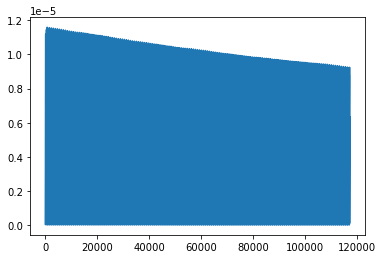

In [18]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.07)
pltdata7 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata7)

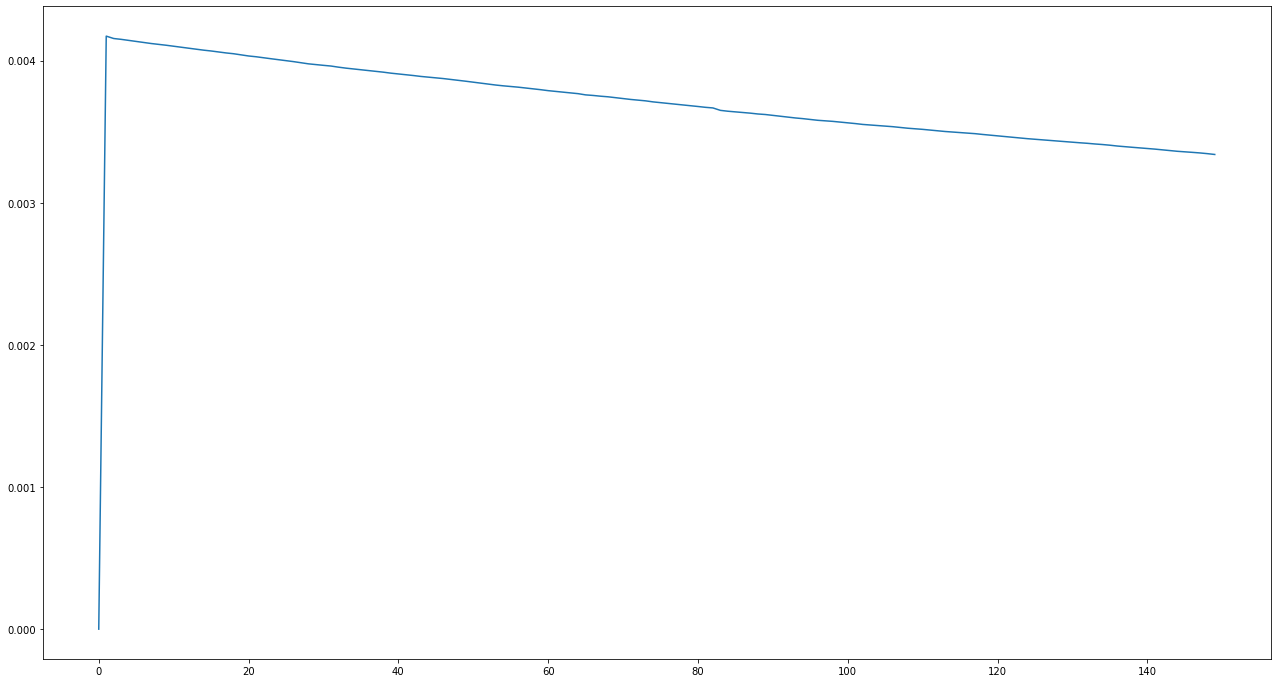

In [73]:
avg7 = 0
avgLossPerEpoch7 = []
for i in range(len(pltdata7)):
    avg7 = avg7 + pltdata7[i]
    if(i%780==0):
        avgLossPerEpoch7.append(avg7)
        avg7 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch7[0:150])       

learning rate  0.08
dev  cuda
[1,   100] loss: 0.0000000891
[1,   200] loss: 0.0000000870
[1,   300] loss: 0.0000000803
[1,   400] loss: 0.0000000917
[1,   500] loss: 0.0000000817
[1,   600] loss: 0.0000000876
[1,   700] loss: 0.0000000923
[2,   100] loss: 0.0000000890
[2,   200] loss: 0.0000000869
[2,   300] loss: 0.0000000802
[2,   400] loss: 0.0000000915
[2,   500] loss: 0.0000000816
[2,   600] loss: 0.0000000875
[2,   700] loss: 0.0000000922
[3,   100] loss: 0.0000000889
[3,   200] loss: 0.0000000866
[3,   300] loss: 0.0000000801
[3,   400] loss: 0.0000000913
[3,   500] loss: 0.0000000815
[3,   600] loss: 0.0000000873
[3,   700] loss: 0.0000000921
[4,   100] loss: 0.0000000888
[4,   200] loss: 0.0000000864
[4,   300] loss: 0.0000000800
[4,   400] loss: 0.0000000911
[4,   500] loss: 0.0000000814
[4,   600] loss: 0.0000000872
[4,   700] loss: 0.0000000919
[5,   100] loss: 0.0000000886
[5,   200] loss: 0.0000000863
[5,   300] loss: 0.0000000798
[5,   400] loss: 0.0000000911
[5,   500]

[39,   100] loss: 0.0000000842
[39,   200] loss: 0.0000000817
[39,   300] loss: 0.0000000753
[39,   400] loss: 0.0000000864
[39,   500] loss: 0.0000000768
[39,   600] loss: 0.0000000827
[39,   700] loss: 0.0000000869
[40,   100] loss: 0.0000000841
[40,   200] loss: 0.0000000816
[40,   300] loss: 0.0000000753
[40,   400] loss: 0.0000000863
[40,   500] loss: 0.0000000767
[40,   600] loss: 0.0000000825
[40,   700] loss: 0.0000000869
[41,   100] loss: 0.0000000840
[41,   200] loss: 0.0000000814
[41,   300] loss: 0.0000000752
[41,   400] loss: 0.0000000862
[41,   500] loss: 0.0000000767
[41,   600] loss: 0.0000000824
[41,   700] loss: 0.0000000868
[42,   100] loss: 0.0000000839
[42,   200] loss: 0.0000000813
[42,   300] loss: 0.0000000751
[42,   400] loss: 0.0000000861
[42,   500] loss: 0.0000000765
[42,   600] loss: 0.0000000822
[42,   700] loss: 0.0000000867
[43,   100] loss: 0.0000000838
[43,   200] loss: 0.0000000812
[43,   300] loss: 0.0000000750
[43,   400] loss: 0.0000000859
[43,   5

[76,   700] loss: 0.0000000830
[77,   100] loss: 0.0000000798
[77,   200] loss: 0.0000000774
[77,   300] loss: 0.0000000714
[77,   400] loss: 0.0000000825
[77,   500] loss: 0.0000000728
[77,   600] loss: 0.0000000785
[77,   700] loss: 0.0000000829
[78,   100] loss: 0.0000000797
[78,   200] loss: 0.0000000772
[78,   300] loss: 0.0000000713
[78,   400] loss: 0.0000000824
[78,   500] loss: 0.0000000727
[78,   600] loss: 0.0000000784
[78,   700] loss: 0.0000000828
[79,   100] loss: 0.0000000796
[79,   200] loss: 0.0000000771
[79,   300] loss: 0.0000000712
[79,   400] loss: 0.0000000822
[79,   500] loss: 0.0000000726
[79,   600] loss: 0.0000000783
[79,   700] loss: 0.0000000827
[80,   100] loss: 0.0000000796
[80,   200] loss: 0.0000000771
[80,   300] loss: 0.0000000710
[80,   400] loss: 0.0000000820
[80,   500] loss: 0.0000000724
[80,   600] loss: 0.0000000782
[80,   700] loss: 0.0000000827
[81,   100] loss: 0.0000000794
[81,   200] loss: 0.0000000769
[81,   300] loss: 0.0000000709
[81,   4

[114,   300] loss: 0.0000000679
[114,   400] loss: 0.0000000785
[114,   500] loss: 0.0000000693
[114,   600] loss: 0.0000000750
[114,   700] loss: 0.0000000787
[115,   100] loss: 0.0000000759
[115,   200] loss: 0.0000000737
[115,   300] loss: 0.0000000678
[115,   400] loss: 0.0000000784
[115,   500] loss: 0.0000000691
[115,   600] loss: 0.0000000750
[115,   700] loss: 0.0000000785
[116,   100] loss: 0.0000000757
[116,   200] loss: 0.0000000737
[116,   300] loss: 0.0000000677
[116,   400] loss: 0.0000000783
[116,   500] loss: 0.0000000690
[116,   600] loss: 0.0000000748
[116,   700] loss: 0.0000000785
[117,   100] loss: 0.0000000757
[117,   200] loss: 0.0000000736
[117,   300] loss: 0.0000000676
[117,   400] loss: 0.0000000782
[117,   500] loss: 0.0000000689
[117,   600] loss: 0.0000000748
[117,   700] loss: 0.0000000784
[118,   100] loss: 0.0000000755
[118,   200] loss: 0.0000000736
[118,   300] loss: 0.0000000675
[118,   400] loss: 0.0000000781
[118,   500] loss: 0.0000000688
[118,   

Finished Training on GPU
Accuracy of plane : 89.09 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 78.48 %
Accuracy of   cat : 64.38 %
Accuracy of  deer : 81.82 %
Accuracy of   dog : 79.31 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 83.33 %
Accuracy of the network on the 9984 test images: 83.89 %


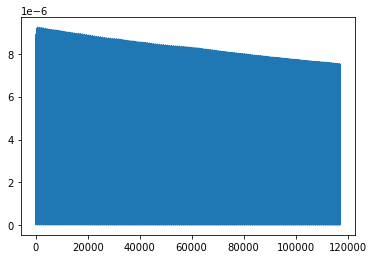

In [19]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.08)
pltdata8 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata8)

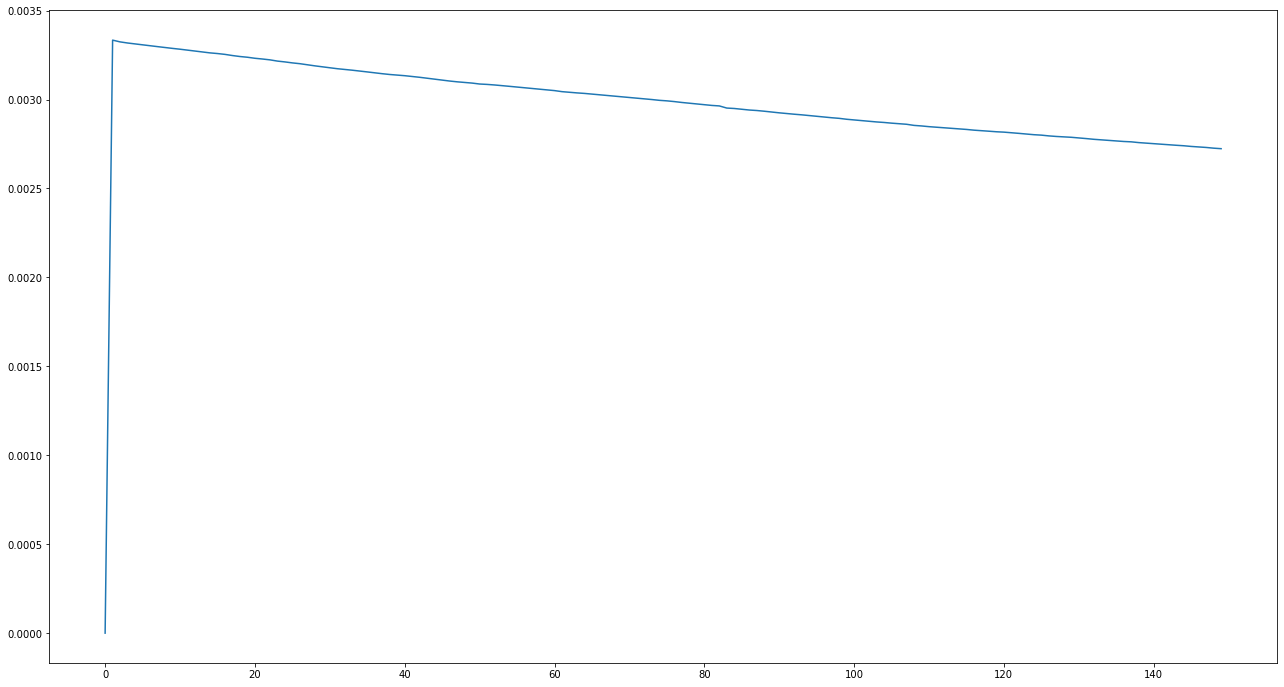

In [74]:
avg8 = 0
avgLossPerEpoch8 = []
for i in range(len(pltdata8)):
    avg8 = avg8 + pltdata8[i]
    if(i%780==0):
        avgLossPerEpoch8.append(avg8)
        avg8 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch8[0:150])       

learning rate  0.09
dev  cuda
[1,   100] loss: 0.0000000728
[1,   200] loss: 0.0000000709
[1,   300] loss: 0.0000000651
[1,   400] loss: 0.0000000752
[1,   500] loss: 0.0000000663
[1,   600] loss: 0.0000000716
[1,   700] loss: 0.0000000750
[2,   100] loss: 0.0000000727
[2,   200] loss: 0.0000000709
[2,   300] loss: 0.0000000650
[2,   400] loss: 0.0000000752
[2,   500] loss: 0.0000000662
[2,   600] loss: 0.0000000715
[2,   700] loss: 0.0000000749
[3,   100] loss: 0.0000000726
[3,   200] loss: 0.0000000707
[3,   300] loss: 0.0000000650
[3,   400] loss: 0.0000000750
[3,   500] loss: 0.0000000661
[3,   600] loss: 0.0000000714
[3,   700] loss: 0.0000000748
[4,   100] loss: 0.0000000725
[4,   200] loss: 0.0000000707
[4,   300] loss: 0.0000000649
[4,   400] loss: 0.0000000749
[4,   500] loss: 0.0000000661
[4,   600] loss: 0.0000000713
[4,   700] loss: 0.0000000748
[5,   100] loss: 0.0000000724
[5,   200] loss: 0.0000000706
[5,   300] loss: 0.0000000649
[5,   400] loss: 0.0000000747
[5,   500]

[39,   100] loss: 0.0000000688
[39,   200] loss: 0.0000000673
[39,   300] loss: 0.0000000615
[39,   400] loss: 0.0000000711
[39,   500] loss: 0.0000000631
[39,   600] loss: 0.0000000680
[39,   700] loss: 0.0000000715
[40,   100] loss: 0.0000000688
[40,   200] loss: 0.0000000671
[40,   300] loss: 0.0000000614
[40,   400] loss: 0.0000000711
[40,   500] loss: 0.0000000630
[40,   600] loss: 0.0000000679
[40,   700] loss: 0.0000000715
[41,   100] loss: 0.0000000687
[41,   200] loss: 0.0000000670
[41,   300] loss: 0.0000000614
[41,   400] loss: 0.0000000710
[41,   500] loss: 0.0000000630
[41,   600] loss: 0.0000000678
[41,   700] loss: 0.0000000714
[42,   100] loss: 0.0000000685
[42,   200] loss: 0.0000000670
[42,   300] loss: 0.0000000614
[42,   400] loss: 0.0000000709
[42,   500] loss: 0.0000000628
[42,   600] loss: 0.0000000677
[42,   700] loss: 0.0000000714
[43,   100] loss: 0.0000000685
[43,   200] loss: 0.0000000668
[43,   300] loss: 0.0000000613
[43,   400] loss: 0.0000000708
[43,   5

[76,   700] loss: 0.0000000681
[77,   100] loss: 0.0000000658
[77,   200] loss: 0.0000000640
[77,   300] loss: 0.0000000587
[77,   400] loss: 0.0000000679
[77,   500] loss: 0.0000000602
[77,   600] loss: 0.0000000646
[77,   700] loss: 0.0000000680
[78,   100] loss: 0.0000000658
[78,   200] loss: 0.0000000640
[78,   300] loss: 0.0000000586
[78,   400] loss: 0.0000000679
[78,   500] loss: 0.0000000601
[78,   600] loss: 0.0000000645
[78,   700] loss: 0.0000000680
[79,   100] loss: 0.0000000657
[79,   200] loss: 0.0000000639
[79,   300] loss: 0.0000000585
[79,   400] loss: 0.0000000677
[79,   500] loss: 0.0000000600
[79,   600] loss: 0.0000000644
[79,   700] loss: 0.0000000679
[80,   100] loss: 0.0000000656
[80,   200] loss: 0.0000000638
[80,   300] loss: 0.0000000584
[80,   400] loss: 0.0000000676
[80,   500] loss: 0.0000000600
[80,   600] loss: 0.0000000644
[80,   700] loss: 0.0000000678
[81,   100] loss: 0.0000000654
[81,   200] loss: 0.0000000637
[81,   300] loss: 0.0000000584
[81,   4

[114,   300] loss: 0.0000000564
[114,   400] loss: 0.0000000652
[114,   500] loss: 0.0000000577
[114,   600] loss: 0.0000000622
[114,   700] loss: 0.0000000647
[115,   100] loss: 0.0000000629
[115,   200] loss: 0.0000000609
[115,   300] loss: 0.0000000563
[115,   400] loss: 0.0000000652
[115,   500] loss: 0.0000000577
[115,   600] loss: 0.0000000621
[115,   700] loss: 0.0000000647
[116,   100] loss: 0.0000000628
[116,   200] loss: 0.0000000608
[116,   300] loss: 0.0000000563
[116,   400] loss: 0.0000000652
[116,   500] loss: 0.0000000576
[116,   600] loss: 0.0000000621
[116,   700] loss: 0.0000000646
[117,   100] loss: 0.0000000628
[117,   200] loss: 0.0000000608
[117,   300] loss: 0.0000000562
[117,   400] loss: 0.0000000650
[117,   500] loss: 0.0000000576
[117,   600] loss: 0.0000000620
[117,   700] loss: 0.0000000646
[118,   100] loss: 0.0000000627
[118,   200] loss: 0.0000000608
[118,   300] loss: 0.0000000561
[118,   400] loss: 0.0000000650
[118,   500] loss: 0.0000000575
[118,   

Finished Training on GPU
Accuracy of plane : 89.09 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 78.48 %
Accuracy of   cat : 64.38 %
Accuracy of  deer : 81.82 %
Accuracy of   dog : 79.31 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 83.33 %
Accuracy of the network on the 9984 test images: 83.91 %


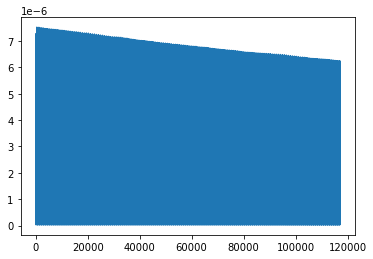

In [20]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.09)
pltdata9 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata9)

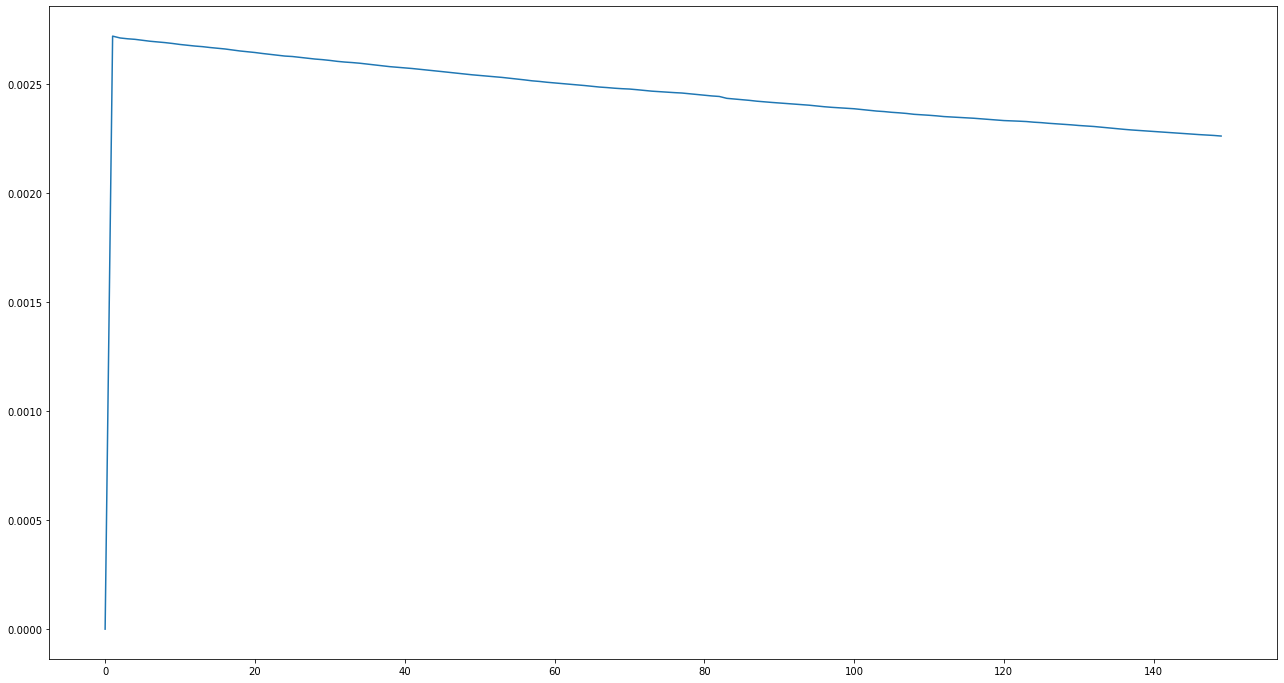

In [75]:
avg9 = 0
avgLossPerEpoch9 = []
for i in range(len(pltdata9)):
    avg9 = avg9 + pltdata9[i]
    if(i%780==0):
        avgLossPerEpoch9.append(avg9)
        avg9 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch9[0:150])       

learning rate  0.2
dev  cuda
[1,   100] loss: 0.0000000606
[1,   200] loss: 0.0000000584
[1,   300] loss: 0.0000000541
[1,   400] loss: 0.0000000624
[1,   500] loss: 0.0000000554
[1,   600] loss: 0.0000000596
[1,   700] loss: 0.0000000624
[2,   100] loss: 0.0000000604
[2,   200] loss: 0.0000000582
[2,   300] loss: 0.0000000539
[2,   400] loss: 0.0000000621
[2,   500] loss: 0.0000000553
[2,   600] loss: 0.0000000594
[2,   700] loss: 0.0000000622
[3,   100] loss: 0.0000000602
[3,   200] loss: 0.0000000581
[3,   300] loss: 0.0000000538
[3,   400] loss: 0.0000000620
[3,   500] loss: 0.0000000550
[3,   600] loss: 0.0000000592
[3,   700] loss: 0.0000000620
[4,   100] loss: 0.0000000601
[4,   200] loss: 0.0000000579
[4,   300] loss: 0.0000000536
[4,   400] loss: 0.0000000620
[4,   500] loss: 0.0000000548
[4,   600] loss: 0.0000000590
[4,   700] loss: 0.0000000618
[5,   100] loss: 0.0000000598
[5,   200] loss: 0.0000000578
[5,   300] loss: 0.0000000534
[5,   400] loss: 0.0000000617
[5,   500] 

[39,   100] loss: 0.0000000544
[39,   200] loss: 0.0000000528
[39,   300] loss: 0.0000000484
[39,   400] loss: 0.0000000559
[39,   500] loss: 0.0000000495
[39,   600] loss: 0.0000000536
[39,   700] loss: 0.0000000558
[40,   100] loss: 0.0000000543
[40,   200] loss: 0.0000000526
[40,   300] loss: 0.0000000484
[40,   400] loss: 0.0000000558
[40,   500] loss: 0.0000000493
[40,   600] loss: 0.0000000535
[40,   700] loss: 0.0000000557
[41,   100] loss: 0.0000000542
[41,   200] loss: 0.0000000525
[41,   300] loss: 0.0000000482
[41,   400] loss: 0.0000000556
[41,   500] loss: 0.0000000492
[41,   600] loss: 0.0000000533
[41,   700] loss: 0.0000000556
[42,   100] loss: 0.0000000540
[42,   200] loss: 0.0000000523
[42,   300] loss: 0.0000000481
[42,   400] loss: 0.0000000555
[42,   500] loss: 0.0000000491
[42,   600] loss: 0.0000000531
[42,   700] loss: 0.0000000555
[43,   100] loss: 0.0000000538
[43,   200] loss: 0.0000000521
[43,   300] loss: 0.0000000480
[43,   400] loss: 0.0000000554
[43,   5

[76,   700] loss: 0.0000000507
[77,   100] loss: 0.0000000493
[77,   200] loss: 0.0000000476
[77,   300] loss: 0.0000000442
[77,   400] loss: 0.0000000505
[77,   500] loss: 0.0000000451
[77,   600] loss: 0.0000000482
[77,   700] loss: 0.0000000506
[78,   100] loss: 0.0000000492
[78,   200] loss: 0.0000000475
[78,   300] loss: 0.0000000441
[78,   400] loss: 0.0000000504
[78,   500] loss: 0.0000000449
[78,   600] loss: 0.0000000481
[78,   700] loss: 0.0000000505
[79,   100] loss: 0.0000000491
[79,   200] loss: 0.0000000474
[79,   300] loss: 0.0000000440
[79,   400] loss: 0.0000000503
[79,   500] loss: 0.0000000447
[79,   600] loss: 0.0000000479
[79,   700] loss: 0.0000000504
[80,   100] loss: 0.0000000489
[80,   200] loss: 0.0000000472
[80,   300] loss: 0.0000000439
[80,   400] loss: 0.0000000501
[80,   500] loss: 0.0000000446
[80,   600] loss: 0.0000000479
[80,   700] loss: 0.0000000502
[81,   100] loss: 0.0000000488
[81,   200] loss: 0.0000000472
[81,   300] loss: 0.0000000438
[81,   4

[114,   300] loss: 0.0000000403
[114,   400] loss: 0.0000000463
[114,   500] loss: 0.0000000413
[114,   600] loss: 0.0000000443
[114,   700] loss: 0.0000000463
[115,   100] loss: 0.0000000450
[115,   200] loss: 0.0000000439
[115,   300] loss: 0.0000000402
[115,   400] loss: 0.0000000462
[115,   500] loss: 0.0000000412
[115,   600] loss: 0.0000000441
[115,   700] loss: 0.0000000463
[116,   100] loss: 0.0000000449
[116,   200] loss: 0.0000000439
[116,   300] loss: 0.0000000401
[116,   400] loss: 0.0000000461
[116,   500] loss: 0.0000000412
[116,   600] loss: 0.0000000440
[116,   700] loss: 0.0000000461
[117,   100] loss: 0.0000000448
[117,   200] loss: 0.0000000438
[117,   300] loss: 0.0000000400
[117,   400] loss: 0.0000000460
[117,   500] loss: 0.0000000410
[117,   600] loss: 0.0000000439
[117,   700] loss: 0.0000000460
[118,   100] loss: 0.0000000447
[118,   200] loss: 0.0000000437
[118,   300] loss: 0.0000000399
[118,   400] loss: 0.0000000458
[118,   500] loss: 0.0000000410
[118,   

Finished Training on GPU
Accuracy of plane : 89.09 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 78.48 %
Accuracy of   cat : 64.38 %
Accuracy of  deer : 81.82 %
Accuracy of   dog : 79.31 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 83.33 %
Accuracy of the network on the 9984 test images: 83.93 %


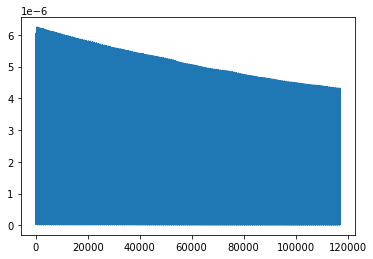

In [21]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.2)
pltdata10 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata10)

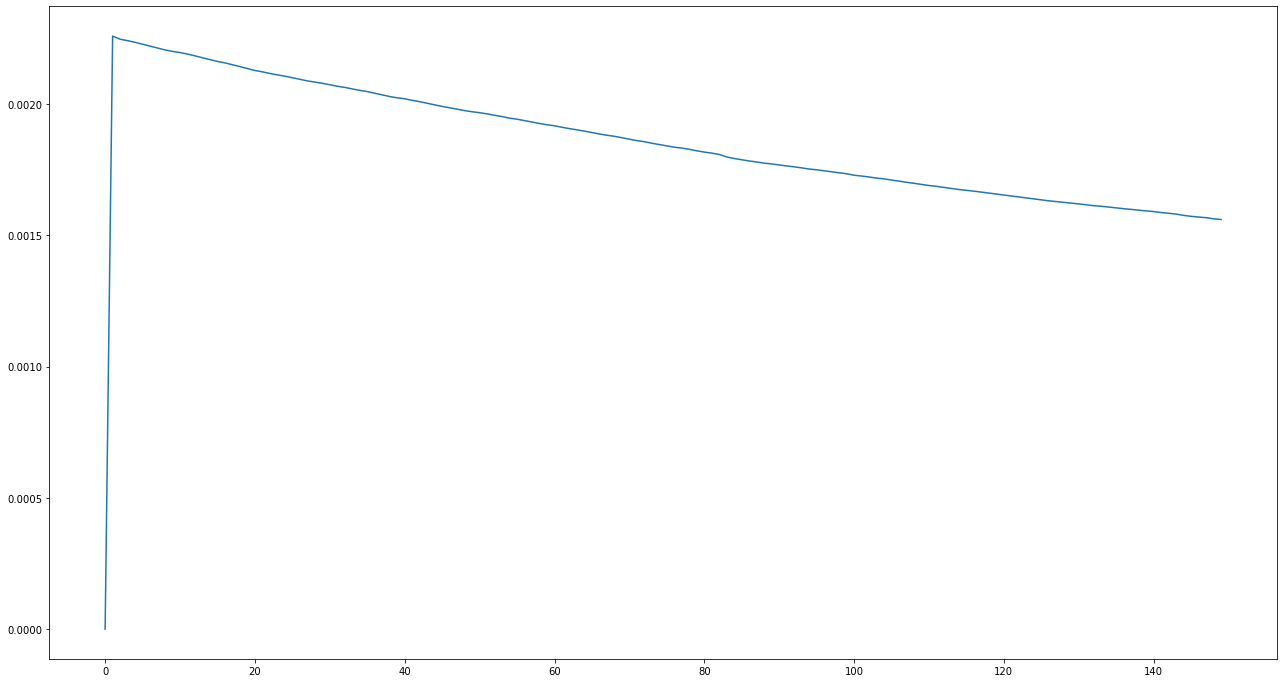

In [76]:
avg10 = 0
avgLossPerEpoch10 = []
for i in range(len(pltdata10)):
    avg10 = avg10 + pltdata10[i]
    if(i%780==0):
        avgLossPerEpoch10.append(avg10)
        avg10 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch10[0:150])       

learning rate  0.3
dev  cuda
[1,   100] loss: 0.0000000419
[1,   200] loss: 0.0000000406
[1,   300] loss: 0.0000000370
[1,   400] loss: 0.0000000431
[1,   500] loss: 0.0000000382
[1,   600] loss: 0.0000000408
[1,   700] loss: 0.0000000430
[2,   100] loss: 0.0000000417
[2,   200] loss: 0.0000000404
[2,   300] loss: 0.0000000369
[2,   400] loss: 0.0000000429
[2,   500] loss: 0.0000000380
[2,   600] loss: 0.0000000406
[2,   700] loss: 0.0000000429
[3,   100] loss: 0.0000000416
[3,   200] loss: 0.0000000403
[3,   300] loss: 0.0000000369
[3,   400] loss: 0.0000000428
[3,   500] loss: 0.0000000378
[3,   600] loss: 0.0000000405
[3,   700] loss: 0.0000000428
[4,   100] loss: 0.0000000415
[4,   200] loss: 0.0000000401
[4,   300] loss: 0.0000000368
[4,   400] loss: 0.0000000426
[4,   500] loss: 0.0000000376
[4,   600] loss: 0.0000000404
[4,   700] loss: 0.0000000427
[5,   100] loss: 0.0000000414
[5,   200] loss: 0.0000000400
[5,   300] loss: 0.0000000367
[5,   400] loss: 0.0000000425
[5,   500] 

[39,   100] loss: 0.0000000374
[39,   200] loss: 0.0000000358
[39,   300] loss: 0.0000000330
[39,   400] loss: 0.0000000381
[39,   500] loss: 0.0000000337
[39,   600] loss: 0.0000000363
[39,   700] loss: 0.0000000383
[40,   100] loss: 0.0000000373
[40,   200] loss: 0.0000000357
[40,   300] loss: 0.0000000329
[40,   400] loss: 0.0000000379
[40,   500] loss: 0.0000000336
[40,   600] loss: 0.0000000362
[40,   700] loss: 0.0000000382
[41,   100] loss: 0.0000000372
[41,   200] loss: 0.0000000356
[41,   300] loss: 0.0000000328
[41,   400] loss: 0.0000000378
[41,   500] loss: 0.0000000335
[41,   600] loss: 0.0000000361
[41,   700] loss: 0.0000000381
[42,   100] loss: 0.0000000371
[42,   200] loss: 0.0000000355
[42,   300] loss: 0.0000000328
[42,   400] loss: 0.0000000378
[42,   500] loss: 0.0000000334
[42,   600] loss: 0.0000000360
[42,   700] loss: 0.0000000381
[43,   100] loss: 0.0000000369
[43,   200] loss: 0.0000000354
[43,   300] loss: 0.0000000327
[43,   400] loss: 0.0000000376
[43,   5

[76,   700] loss: 0.0000000347
[77,   100] loss: 0.0000000336
[77,   200] loss: 0.0000000324
[77,   300] loss: 0.0000000297
[77,   400] loss: 0.0000000343
[77,   500] loss: 0.0000000302
[77,   600] loss: 0.0000000327
[77,   700] loss: 0.0000000346
[78,   100] loss: 0.0000000335
[78,   200] loss: 0.0000000323
[78,   300] loss: 0.0000000296
[78,   400] loss: 0.0000000342
[78,   500] loss: 0.0000000302
[78,   600] loss: 0.0000000327
[78,   700] loss: 0.0000000345
[79,   100] loss: 0.0000000334
[79,   200] loss: 0.0000000322
[79,   300] loss: 0.0000000295
[79,   400] loss: 0.0000000341
[79,   500] loss: 0.0000000301
[79,   600] loss: 0.0000000326
[79,   700] loss: 0.0000000343
[80,   100] loss: 0.0000000333
[80,   200] loss: 0.0000000321
[80,   300] loss: 0.0000000294
[80,   400] loss: 0.0000000340
[80,   500] loss: 0.0000000300
[80,   600] loss: 0.0000000325
[80,   700] loss: 0.0000000343
[81,   100] loss: 0.0000000332
[81,   200] loss: 0.0000000321
[81,   300] loss: 0.0000000293
[81,   4

[114,   300] loss: 0.0000000272
[114,   400] loss: 0.0000000313
[114,   500] loss: 0.0000000274
[114,   600] loss: 0.0000000300
[114,   700] loss: 0.0000000314
[115,   100] loss: 0.0000000304
[115,   200] loss: 0.0000000295
[115,   300] loss: 0.0000000272
[115,   400] loss: 0.0000000312
[115,   500] loss: 0.0000000274
[115,   600] loss: 0.0000000299
[115,   700] loss: 0.0000000313
[116,   100] loss: 0.0000000304
[116,   200] loss: 0.0000000295
[116,   300] loss: 0.0000000271
[116,   400] loss: 0.0000000311
[116,   500] loss: 0.0000000274
[116,   600] loss: 0.0000000298
[116,   700] loss: 0.0000000313
[117,   100] loss: 0.0000000303
[117,   200] loss: 0.0000000294
[117,   300] loss: 0.0000000270
[117,   400] loss: 0.0000000311
[117,   500] loss: 0.0000000273
[117,   600] loss: 0.0000000297
[117,   700] loss: 0.0000000313
[118,   100] loss: 0.0000000302
[118,   200] loss: 0.0000000293
[118,   300] loss: 0.0000000269
[118,   400] loss: 0.0000000310
[118,   500] loss: 0.0000000273
[118,   

Finished Training on GPU
Accuracy of plane : 89.09 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 78.48 %
Accuracy of   cat : 64.38 %
Accuracy of  deer : 81.82 %
Accuracy of   dog : 79.31 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 83.33 %
Accuracy of the network on the 9984 test images: 83.93 %


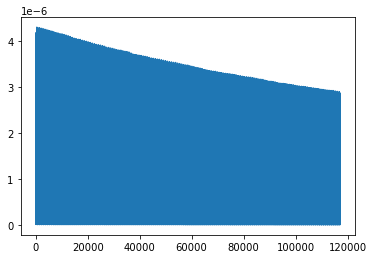

In [22]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.3)
pltdata11 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata11)

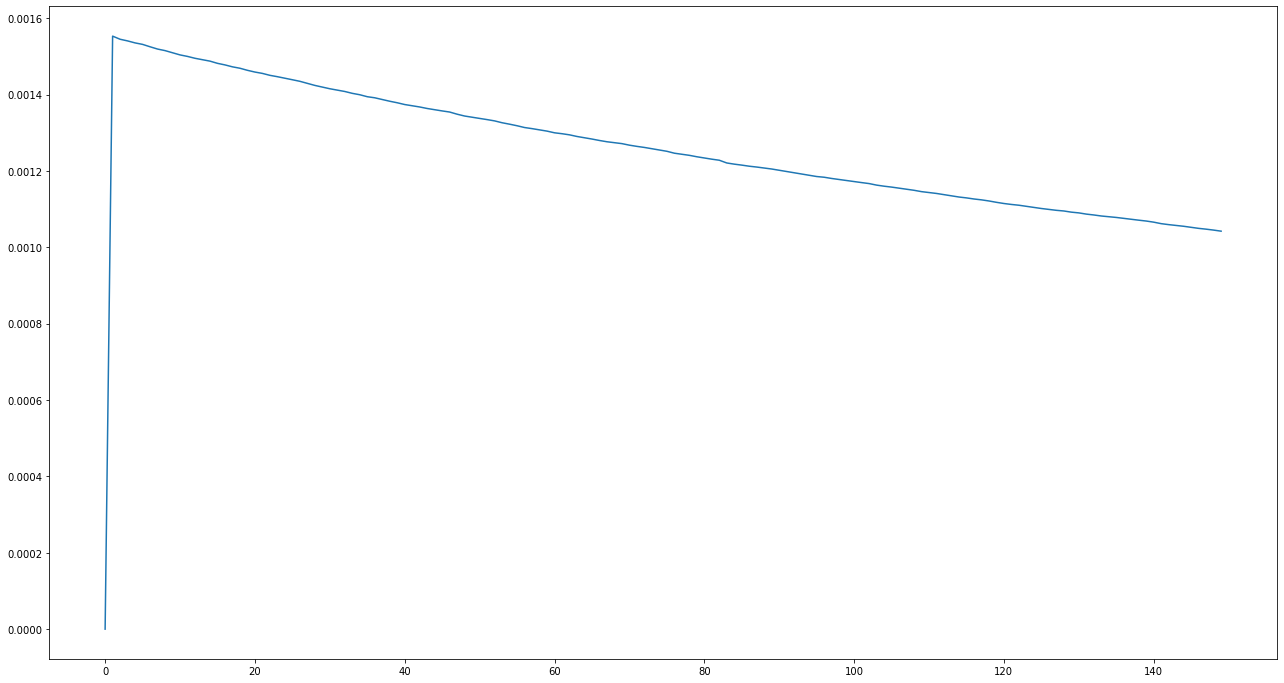

In [77]:
avg11 = 0
avgLossPerEpoch11 = []
for i in range(len(pltdata11)):
    avg11 = avg11+ pltdata11[i]
    if(i%780==0):
        avgLossPerEpoch11.append(avg11)
        avg11 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch11[0:150])       

learning rate  0.4
dev  cuda
[1,   100] loss: 0.0000000280
[1,   200] loss: 0.0000000271
[1,   300] loss: 0.0000000250
[1,   400] loss: 0.0000000290
[1,   500] loss: 0.0000000254
[1,   600] loss: 0.0000000274
[1,   700] loss: 0.0000000287
[2,   100] loss: 0.0000000279
[2,   200] loss: 0.0000000270
[2,   300] loss: 0.0000000249
[2,   400] loss: 0.0000000289
[2,   500] loss: 0.0000000254
[2,   600] loss: 0.0000000273
[2,   700] loss: 0.0000000286
[3,   100] loss: 0.0000000279
[3,   200] loss: 0.0000000269
[3,   300] loss: 0.0000000249
[3,   400] loss: 0.0000000288
[3,   500] loss: 0.0000000253
[3,   600] loss: 0.0000000273
[3,   700] loss: 0.0000000286
[4,   100] loss: 0.0000000278
[4,   200] loss: 0.0000000268
[4,   300] loss: 0.0000000248
[4,   400] loss: 0.0000000287
[4,   500] loss: 0.0000000251
[4,   600] loss: 0.0000000272
[4,   700] loss: 0.0000000285
[5,   100] loss: 0.0000000277
[5,   200] loss: 0.0000000267
[5,   300] loss: 0.0000000248
[5,   400] loss: 0.0000000286
[5,   500] 

[39,   100] loss: 0.0000000256
[39,   200] loss: 0.0000000244
[39,   300] loss: 0.0000000223
[39,   400] loss: 0.0000000262
[39,   500] loss: 0.0000000229
[39,   600] loss: 0.0000000246
[39,   700] loss: 0.0000000257
[40,   100] loss: 0.0000000256
[40,   200] loss: 0.0000000243
[40,   300] loss: 0.0000000222
[40,   400] loss: 0.0000000261
[40,   500] loss: 0.0000000228
[40,   600] loss: 0.0000000245
[40,   700] loss: 0.0000000257
[41,   100] loss: 0.0000000255
[41,   200] loss: 0.0000000242
[41,   300] loss: 0.0000000222
[41,   400] loss: 0.0000000259
[41,   500] loss: 0.0000000228
[41,   600] loss: 0.0000000245
[41,   700] loss: 0.0000000256
[42,   100] loss: 0.0000000254
[42,   200] loss: 0.0000000241
[42,   300] loss: 0.0000000221
[42,   400] loss: 0.0000000259
[42,   500] loss: 0.0000000227
[42,   600] loss: 0.0000000244
[42,   700] loss: 0.0000000256
[43,   100] loss: 0.0000000254
[43,   200] loss: 0.0000000241
[43,   300] loss: 0.0000000221
[43,   400] loss: 0.0000000258
[43,   5

[76,   700] loss: 0.0000000233
[77,   100] loss: 0.0000000233
[77,   200] loss: 0.0000000219
[77,   300] loss: 0.0000000204
[77,   400] loss: 0.0000000236
[77,   500] loss: 0.0000000205
[77,   600] loss: 0.0000000223
[77,   700] loss: 0.0000000232
[78,   100] loss: 0.0000000232
[78,   200] loss: 0.0000000219
[78,   300] loss: 0.0000000204
[78,   400] loss: 0.0000000235
[78,   500] loss: 0.0000000205
[78,   600] loss: 0.0000000222
[78,   700] loss: 0.0000000232
[79,   100] loss: 0.0000000232
[79,   200] loss: 0.0000000218
[79,   300] loss: 0.0000000204
[79,   400] loss: 0.0000000234
[79,   500] loss: 0.0000000205
[79,   600] loss: 0.0000000222
[79,   700] loss: 0.0000000232
[80,   100] loss: 0.0000000231
[80,   200] loss: 0.0000000217
[80,   300] loss: 0.0000000204
[80,   400] loss: 0.0000000234
[80,   500] loss: 0.0000000203
[80,   600] loss: 0.0000000221
[80,   700] loss: 0.0000000231
[81,   100] loss: 0.0000000230
[81,   200] loss: 0.0000000216
[81,   300] loss: 0.0000000204
[81,   4

[114,   300] loss: 0.0000000186
[114,   400] loss: 0.0000000214
[114,   500] loss: 0.0000000189
[114,   600] loss: 0.0000000201
[114,   700] loss: 0.0000000217
[115,   100] loss: 0.0000000212
[115,   200] loss: 0.0000000199
[115,   300] loss: 0.0000000186
[115,   400] loss: 0.0000000213
[115,   500] loss: 0.0000000189
[115,   600] loss: 0.0000000201
[115,   700] loss: 0.0000000217
[116,   100] loss: 0.0000000211
[116,   200] loss: 0.0000000199
[116,   300] loss: 0.0000000185
[116,   400] loss: 0.0000000213
[116,   500] loss: 0.0000000189
[116,   600] loss: 0.0000000200
[116,   700] loss: 0.0000000216
[117,   100] loss: 0.0000000210
[117,   200] loss: 0.0000000199
[117,   300] loss: 0.0000000185
[117,   400] loss: 0.0000000213
[117,   500] loss: 0.0000000188
[117,   600] loss: 0.0000000200
[117,   700] loss: 0.0000000216
[118,   100] loss: 0.0000000210
[118,   200] loss: 0.0000000199
[118,   300] loss: 0.0000000184
[118,   400] loss: 0.0000000212
[118,   500] loss: 0.0000000188
[118,   

Finished Training on GPU
Accuracy of plane : 89.09 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 78.48 %
Accuracy of   cat : 64.38 %
Accuracy of  deer : 81.82 %
Accuracy of   dog : 77.59 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 83.33 %
Accuracy of the network on the 9984 test images: 83.96 %


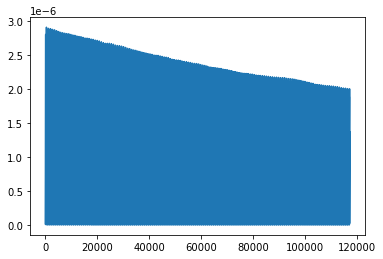

In [23]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.4)
pltdata12 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata12)

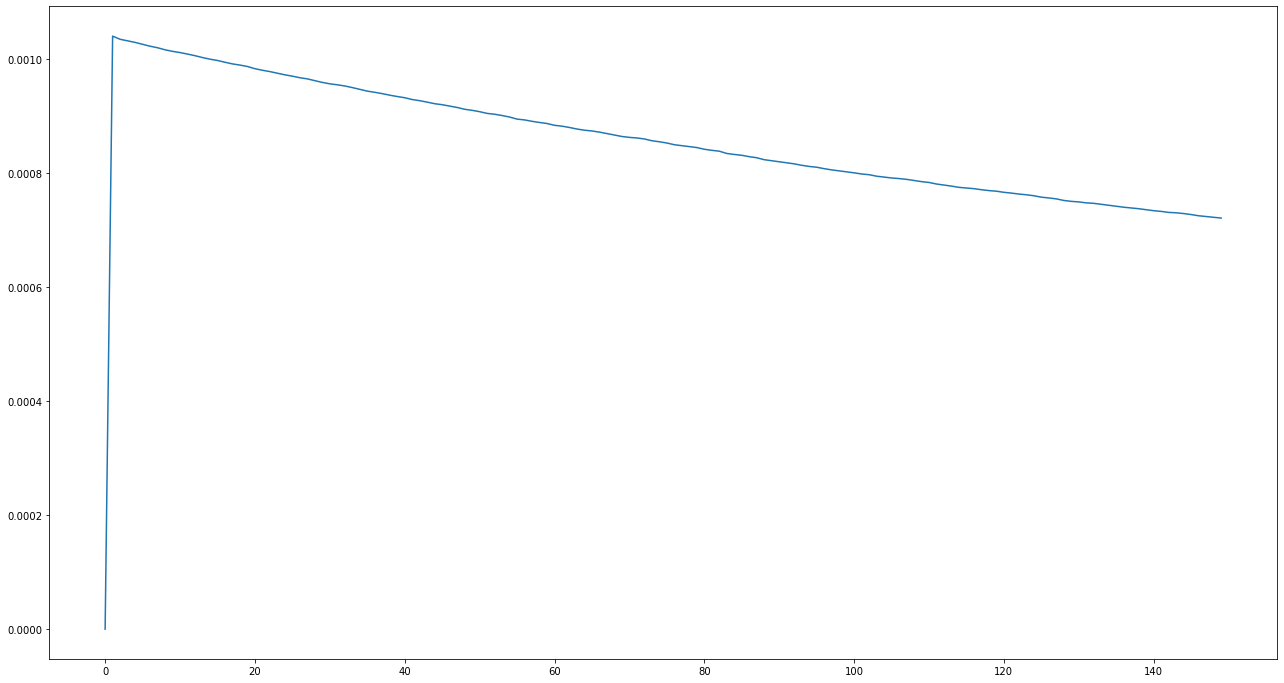

In [79]:
avg12 = 0
avgLossPerEpoch12 = []
for i in range(len(pltdata12)):
    avg12 = avg12 + pltdata12[i]
    if(i%780==0):
        avgLossPerEpoch12.append(avg12)
        avg12 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch12[0:150])       

learning rate  0.5
dev  cuda
[1,   100] loss: 0.0000000194
[1,   200] loss: 0.0000000186
[1,   300] loss: 0.0000000170
[1,   400] loss: 0.0000000198
[1,   500] loss: 0.0000000176
[1,   600] loss: 0.0000000188
[1,   700] loss: 0.0000000199
[2,   100] loss: 0.0000000194
[2,   200] loss: 0.0000000186
[2,   300] loss: 0.0000000170
[2,   400] loss: 0.0000000198
[2,   500] loss: 0.0000000175
[2,   600] loss: 0.0000000187
[2,   700] loss: 0.0000000199
[3,   100] loss: 0.0000000194
[3,   200] loss: 0.0000000185
[3,   300] loss: 0.0000000170
[3,   400] loss: 0.0000000197
[3,   500] loss: 0.0000000175
[3,   600] loss: 0.0000000186
[3,   700] loss: 0.0000000199
[4,   100] loss: 0.0000000194
[4,   200] loss: 0.0000000185
[4,   300] loss: 0.0000000169
[4,   400] loss: 0.0000000197
[4,   500] loss: 0.0000000174
[4,   600] loss: 0.0000000186
[4,   700] loss: 0.0000000198
[5,   100] loss: 0.0000000194
[5,   200] loss: 0.0000000184
[5,   300] loss: 0.0000000169
[5,   400] loss: 0.0000000197
[5,   500] 

[39,   100] loss: 0.0000000177
[39,   200] loss: 0.0000000169
[39,   300] loss: 0.0000000152
[39,   400] loss: 0.0000000183
[39,   500] loss: 0.0000000159
[39,   600] loss: 0.0000000168
[39,   700] loss: 0.0000000183
[40,   100] loss: 0.0000000176
[40,   200] loss: 0.0000000169
[40,   300] loss: 0.0000000152
[40,   400] loss: 0.0000000183
[40,   500] loss: 0.0000000159
[40,   600] loss: 0.0000000168
[40,   700] loss: 0.0000000183
[41,   100] loss: 0.0000000176
[41,   200] loss: 0.0000000168
[41,   300] loss: 0.0000000151
[41,   400] loss: 0.0000000182
[41,   500] loss: 0.0000000159
[41,   600] loss: 0.0000000167
[41,   700] loss: 0.0000000183
[42,   100] loss: 0.0000000175
[42,   200] loss: 0.0000000168
[42,   300] loss: 0.0000000150
[42,   400] loss: 0.0000000182
[42,   500] loss: 0.0000000159
[42,   600] loss: 0.0000000167
[42,   700] loss: 0.0000000182
[43,   100] loss: 0.0000000175
[43,   200] loss: 0.0000000168
[43,   300] loss: 0.0000000150
[43,   400] loss: 0.0000000181
[43,   5

[76,   700] loss: 0.0000000170
[77,   100] loss: 0.0000000163
[77,   200] loss: 0.0000000154
[77,   300] loss: 0.0000000138
[77,   400] loss: 0.0000000168
[77,   500] loss: 0.0000000147
[77,   600] loss: 0.0000000151
[77,   700] loss: 0.0000000169
[78,   100] loss: 0.0000000163
[78,   200] loss: 0.0000000154
[78,   300] loss: 0.0000000138
[78,   400] loss: 0.0000000168
[78,   500] loss: 0.0000000146
[78,   600] loss: 0.0000000151
[78,   700] loss: 0.0000000169
[79,   100] loss: 0.0000000163
[79,   200] loss: 0.0000000154
[79,   300] loss: 0.0000000138
[79,   400] loss: 0.0000000167
[79,   500] loss: 0.0000000146
[79,   600] loss: 0.0000000151
[79,   700] loss: 0.0000000168
[80,   100] loss: 0.0000000162
[80,   200] loss: 0.0000000154
[80,   300] loss: 0.0000000138
[80,   400] loss: 0.0000000167
[80,   500] loss: 0.0000000145
[80,   600] loss: 0.0000000151
[80,   700] loss: 0.0000000168
[81,   100] loss: 0.0000000162
[81,   200] loss: 0.0000000153
[81,   300] loss: 0.0000000138
[81,   4

[114,   300] loss: 0.0000000129
[114,   400] loss: 0.0000000158
[114,   500] loss: 0.0000000133
[114,   600] loss: 0.0000000140
[114,   700] loss: 0.0000000155
[115,   100] loss: 0.0000000150
[115,   200] loss: 0.0000000141
[115,   300] loss: 0.0000000129
[115,   400] loss: 0.0000000157
[115,   500] loss: 0.0000000132
[115,   600] loss: 0.0000000140
[115,   700] loss: 0.0000000155
[116,   100] loss: 0.0000000150
[116,   200] loss: 0.0000000140
[116,   300] loss: 0.0000000129
[116,   400] loss: 0.0000000157
[116,   500] loss: 0.0000000132
[116,   600] loss: 0.0000000140
[116,   700] loss: 0.0000000155
[117,   100] loss: 0.0000000150
[117,   200] loss: 0.0000000140
[117,   300] loss: 0.0000000129
[117,   400] loss: 0.0000000157
[117,   500] loss: 0.0000000132
[117,   600] loss: 0.0000000139
[117,   700] loss: 0.0000000155
[118,   100] loss: 0.0000000149
[118,   200] loss: 0.0000000140
[118,   300] loss: 0.0000000128
[118,   400] loss: 0.0000000157
[118,   500] loss: 0.0000000132
[118,   

Finished Training on GPU
Accuracy of plane : 89.09 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 78.48 %
Accuracy of   cat : 64.38 %
Accuracy of  deer : 81.82 %
Accuracy of   dog : 79.31 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 83.33 %
Accuracy of the network on the 9984 test images: 83.98 %


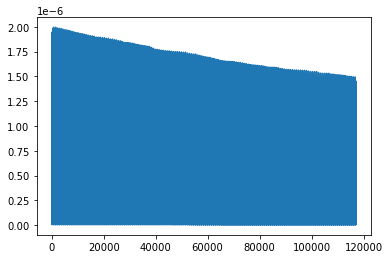

In [24]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.5)
pltdata13 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata13)

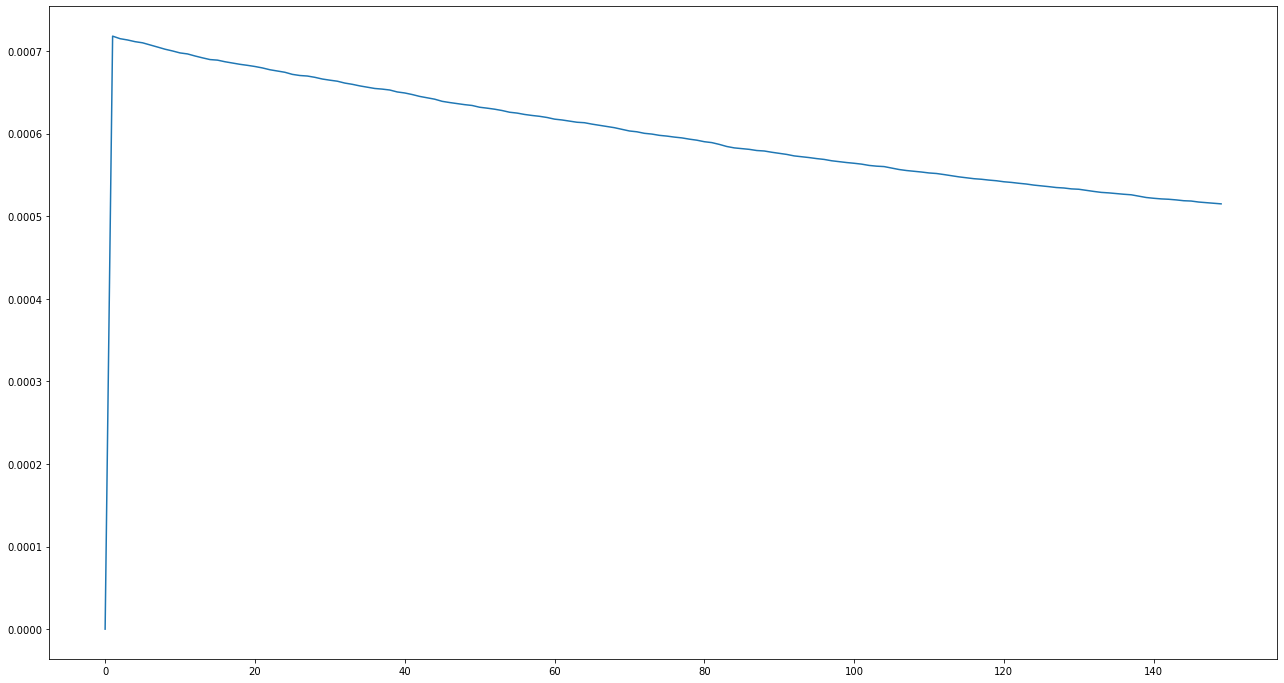

In [81]:
avg13 = 0
avgLossPerEpoch13 = []
for i in range(len(pltdata13)):
    avg13 = avg13 + pltdata13[i]
    if(i%780==0):
        avgLossPerEpoch13.append(avg13)
        avg13 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch13[0:150])       

learning rate  0.6
dev  cuda
[1,   100] loss: 0.0000000140
[1,   200] loss: 0.0000000131
[1,   300] loss: 0.0000000120
[1,   400] loss: 0.0000000149
[1,   500] loss: 0.0000000125
[1,   600] loss: 0.0000000132
[1,   700] loss: 0.0000000144
[2,   100] loss: 0.0000000140
[2,   200] loss: 0.0000000130
[2,   300] loss: 0.0000000120
[2,   400] loss: 0.0000000148
[2,   500] loss: 0.0000000124
[2,   600] loss: 0.0000000131
[2,   700] loss: 0.0000000144
[3,   100] loss: 0.0000000139
[3,   200] loss: 0.0000000130
[3,   300] loss: 0.0000000120
[3,   400] loss: 0.0000000148
[3,   500] loss: 0.0000000124
[3,   600] loss: 0.0000000131
[3,   700] loss: 0.0000000143
[4,   100] loss: 0.0000000139
[4,   200] loss: 0.0000000129
[4,   300] loss: 0.0000000119
[4,   400] loss: 0.0000000148
[4,   500] loss: 0.0000000123
[4,   600] loss: 0.0000000131
[4,   700] loss: 0.0000000143
[5,   100] loss: 0.0000000139
[5,   200] loss: 0.0000000129
[5,   300] loss: 0.0000000119
[5,   400] loss: 0.0000000147
[5,   500] 

[39,   100] loss: 0.0000000126
[39,   200] loss: 0.0000000121
[39,   300] loss: 0.0000000112
[39,   400] loss: 0.0000000136
[39,   500] loss: 0.0000000113
[39,   600] loss: 0.0000000121
[39,   700] loss: 0.0000000132
[40,   100] loss: 0.0000000125
[40,   200] loss: 0.0000000120
[40,   300] loss: 0.0000000111
[40,   400] loss: 0.0000000135
[40,   500] loss: 0.0000000113
[40,   600] loss: 0.0000000120
[40,   700] loss: 0.0000000132
[41,   100] loss: 0.0000000125
[41,   200] loss: 0.0000000120
[41,   300] loss: 0.0000000111
[41,   400] loss: 0.0000000135
[41,   500] loss: 0.0000000113
[41,   600] loss: 0.0000000120
[41,   700] loss: 0.0000000131
[42,   100] loss: 0.0000000125
[42,   200] loss: 0.0000000120
[42,   300] loss: 0.0000000111
[42,   400] loss: 0.0000000135
[42,   500] loss: 0.0000000113
[42,   600] loss: 0.0000000120
[42,   700] loss: 0.0000000130
[43,   100] loss: 0.0000000125
[43,   200] loss: 0.0000000120
[43,   300] loss: 0.0000000110
[43,   400] loss: 0.0000000135
[43,   5

[76,   700] loss: 0.0000000121
[77,   100] loss: 0.0000000116
[77,   200] loss: 0.0000000111
[77,   300] loss: 0.0000000102
[77,   400] loss: 0.0000000123
[77,   500] loss: 0.0000000104
[77,   600] loss: 0.0000000112
[77,   700] loss: 0.0000000121
[78,   100] loss: 0.0000000115
[78,   200] loss: 0.0000000110
[78,   300] loss: 0.0000000101
[78,   400] loss: 0.0000000123
[78,   500] loss: 0.0000000104
[78,   600] loss: 0.0000000112
[78,   700] loss: 0.0000000121
[79,   100] loss: 0.0000000115
[79,   200] loss: 0.0000000110
[79,   300] loss: 0.0000000101
[79,   400] loss: 0.0000000123
[79,   500] loss: 0.0000000104
[79,   600] loss: 0.0000000112
[79,   700] loss: 0.0000000121
[80,   100] loss: 0.0000000114
[80,   200] loss: 0.0000000110
[80,   300] loss: 0.0000000101
[80,   400] loss: 0.0000000122
[80,   500] loss: 0.0000000104
[80,   600] loss: 0.0000000112
[80,   700] loss: 0.0000000120
[81,   100] loss: 0.0000000114
[81,   200] loss: 0.0000000109
[81,   300] loss: 0.0000000101
[81,   4

[114,   300] loss: 0.0000000092
[114,   400] loss: 0.0000000112
[114,   500] loss: 0.0000000097
[114,   600] loss: 0.0000000105
[114,   700] loss: 0.0000000110
[115,   100] loss: 0.0000000107
[115,   200] loss: 0.0000000102
[115,   300] loss: 0.0000000091
[115,   400] loss: 0.0000000112
[115,   500] loss: 0.0000000096
[115,   600] loss: 0.0000000105
[115,   700] loss: 0.0000000110
[116,   100] loss: 0.0000000107
[116,   200] loss: 0.0000000102
[116,   300] loss: 0.0000000091
[116,   400] loss: 0.0000000112
[116,   500] loss: 0.0000000096
[116,   600] loss: 0.0000000105
[116,   700] loss: 0.0000000109
[117,   100] loss: 0.0000000107
[117,   200] loss: 0.0000000102
[117,   300] loss: 0.0000000091
[117,   400] loss: 0.0000000112
[117,   500] loss: 0.0000000096
[117,   600] loss: 0.0000000105
[117,   700] loss: 0.0000000109
[118,   100] loss: 0.0000000107
[118,   200] loss: 0.0000000102
[118,   300] loss: 0.0000000091
[118,   400] loss: 0.0000000111
[118,   500] loss: 0.0000000095
[118,   

Finished Training on GPU
Accuracy of plane : 89.09 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 78.48 %
Accuracy of   cat : 64.38 %
Accuracy of  deer : 81.82 %
Accuracy of   dog : 79.31 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 83.33 %
Accuracy of the network on the 9984 test images: 83.97 %


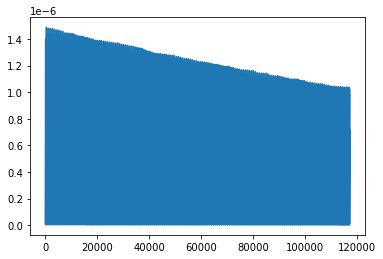

In [25]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.6)
pltdata14 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata14)

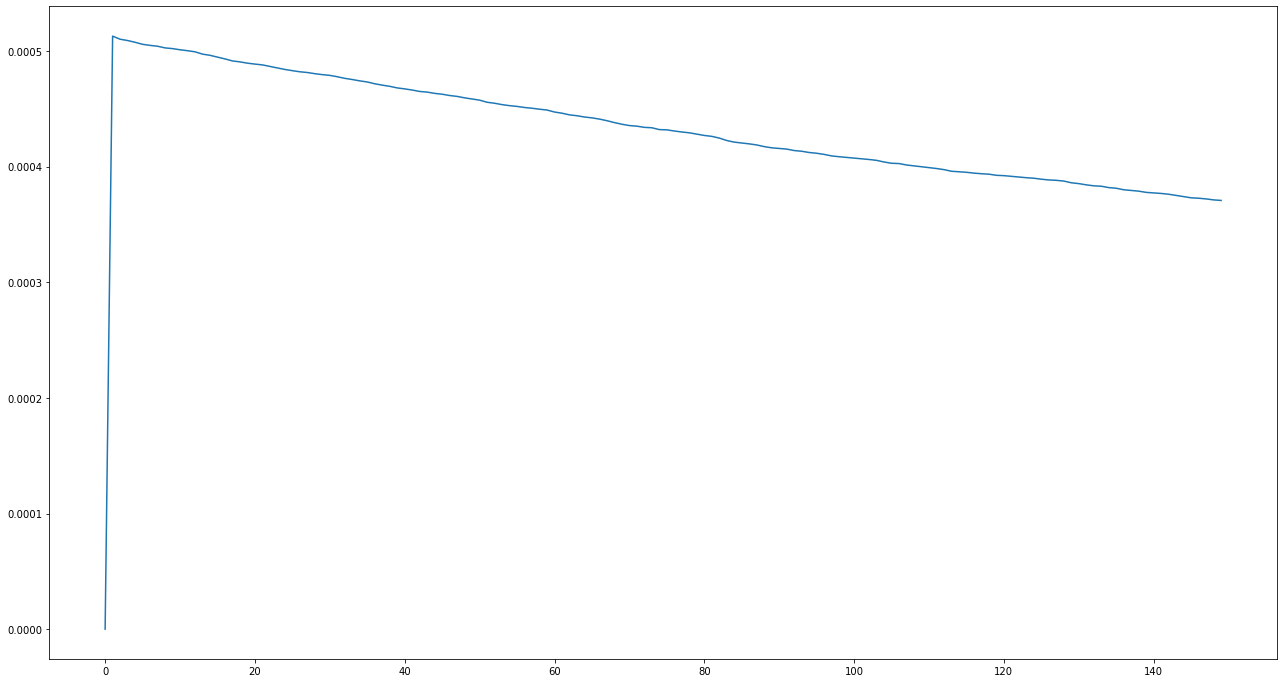

In [82]:
avg14 = 0
avgLossPerEpoch14 = []
for i in range(len(pltdata14)):
    avg14 = avg14 + pltdata14[i]
    if(i%780==0):
        avgLossPerEpoch14.append(avg14)
        avg14 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch14[0:150])       

learning rate  0.7
dev  cuda
[1,   100] loss: 0.0000000101
[1,   200] loss: 0.0000000095
[1,   300] loss: 0.0000000085
[1,   400] loss: 0.0000000104
[1,   500] loss: 0.0000000089
[1,   600] loss: 0.0000000099
[1,   700] loss: 0.0000000102
[2,   100] loss: 0.0000000101
[2,   200] loss: 0.0000000095
[2,   300] loss: 0.0000000085
[2,   400] loss: 0.0000000104
[2,   500] loss: 0.0000000088
[2,   600] loss: 0.0000000098
[2,   700] loss: 0.0000000102
[3,   100] loss: 0.0000000101
[3,   200] loss: 0.0000000095
[3,   300] loss: 0.0000000084
[3,   400] loss: 0.0000000103
[3,   500] loss: 0.0000000088
[3,   600] loss: 0.0000000098
[3,   700] loss: 0.0000000102
[4,   100] loss: 0.0000000101
[4,   200] loss: 0.0000000095
[4,   300] loss: 0.0000000084
[4,   400] loss: 0.0000000102
[4,   500] loss: 0.0000000088
[4,   600] loss: 0.0000000098
[4,   700] loss: 0.0000000102
[5,   100] loss: 0.0000000100
[5,   200] loss: 0.0000000094
[5,   300] loss: 0.0000000084
[5,   400] loss: 0.0000000102
[5,   500] 

[39,   100] loss: 0.0000000091
[39,   200] loss: 0.0000000086
[39,   300] loss: 0.0000000078
[39,   400] loss: 0.0000000094
[39,   500] loss: 0.0000000082
[39,   600] loss: 0.0000000091
[39,   700] loss: 0.0000000094
[40,   100] loss: 0.0000000091
[40,   200] loss: 0.0000000086
[40,   300] loss: 0.0000000078
[40,   400] loss: 0.0000000094
[40,   500] loss: 0.0000000081
[40,   600] loss: 0.0000000091
[40,   700] loss: 0.0000000094
[41,   100] loss: 0.0000000091
[41,   200] loss: 0.0000000086
[41,   300] loss: 0.0000000078
[41,   400] loss: 0.0000000094
[41,   500] loss: 0.0000000081
[41,   600] loss: 0.0000000091
[41,   700] loss: 0.0000000093
[42,   100] loss: 0.0000000091
[42,   200] loss: 0.0000000086
[42,   300] loss: 0.0000000078
[42,   400] loss: 0.0000000094
[42,   500] loss: 0.0000000081
[42,   600] loss: 0.0000000090
[42,   700] loss: 0.0000000093
[43,   100] loss: 0.0000000091
[43,   200] loss: 0.0000000086
[43,   300] loss: 0.0000000078
[43,   400] loss: 0.0000000093
[43,   5

[76,   700] loss: 0.0000000088
[77,   100] loss: 0.0000000084
[77,   200] loss: 0.0000000079
[77,   300] loss: 0.0000000070
[77,   400] loss: 0.0000000087
[77,   500] loss: 0.0000000074
[77,   600] loss: 0.0000000083
[77,   700] loss: 0.0000000088
[78,   100] loss: 0.0000000084
[78,   200] loss: 0.0000000078
[78,   300] loss: 0.0000000070
[78,   400] loss: 0.0000000087
[78,   500] loss: 0.0000000074
[78,   600] loss: 0.0000000082
[78,   700] loss: 0.0000000088
[79,   100] loss: 0.0000000083
[79,   200] loss: 0.0000000078
[79,   300] loss: 0.0000000070
[79,   400] loss: 0.0000000086
[79,   500] loss: 0.0000000074
[79,   600] loss: 0.0000000082
[79,   700] loss: 0.0000000088
[80,   100] loss: 0.0000000083
[80,   200] loss: 0.0000000078
[80,   300] loss: 0.0000000070
[80,   400] loss: 0.0000000086
[80,   500] loss: 0.0000000073
[80,   600] loss: 0.0000000082
[80,   700] loss: 0.0000000087
[81,   100] loss: 0.0000000083
[81,   200] loss: 0.0000000078
[81,   300] loss: 0.0000000070
[81,   4

[114,   300] loss: 0.0000000065
[114,   400] loss: 0.0000000083
[114,   500] loss: 0.0000000070
[114,   600] loss: 0.0000000077
[114,   700] loss: 0.0000000082
[115,   100] loss: 0.0000000077
[115,   200] loss: 0.0000000072
[115,   300] loss: 0.0000000065
[115,   400] loss: 0.0000000083
[115,   500] loss: 0.0000000069
[115,   600] loss: 0.0000000077
[115,   700] loss: 0.0000000082
[116,   100] loss: 0.0000000077
[116,   200] loss: 0.0000000071
[116,   300] loss: 0.0000000065
[116,   400] loss: 0.0000000083
[116,   500] loss: 0.0000000069
[116,   600] loss: 0.0000000076
[116,   700] loss: 0.0000000081
[117,   100] loss: 0.0000000076
[117,   200] loss: 0.0000000071
[117,   300] loss: 0.0000000065
[117,   400] loss: 0.0000000082
[117,   500] loss: 0.0000000069
[117,   600] loss: 0.0000000076
[117,   700] loss: 0.0000000081
[118,   100] loss: 0.0000000077
[118,   200] loss: 0.0000000071
[118,   300] loss: 0.0000000065
[118,   400] loss: 0.0000000082
[118,   500] loss: 0.0000000069
[118,   

Finished Training on GPU
Accuracy of plane : 89.09 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 78.48 %
Accuracy of   cat : 64.38 %
Accuracy of  deer : 81.82 %
Accuracy of   dog : 79.31 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 83.33 %
Accuracy of the network on the 9984 test images: 83.98 %


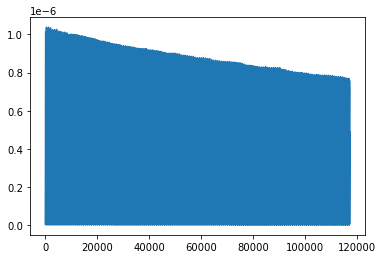

In [26]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.7)
pltdata15 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata15)

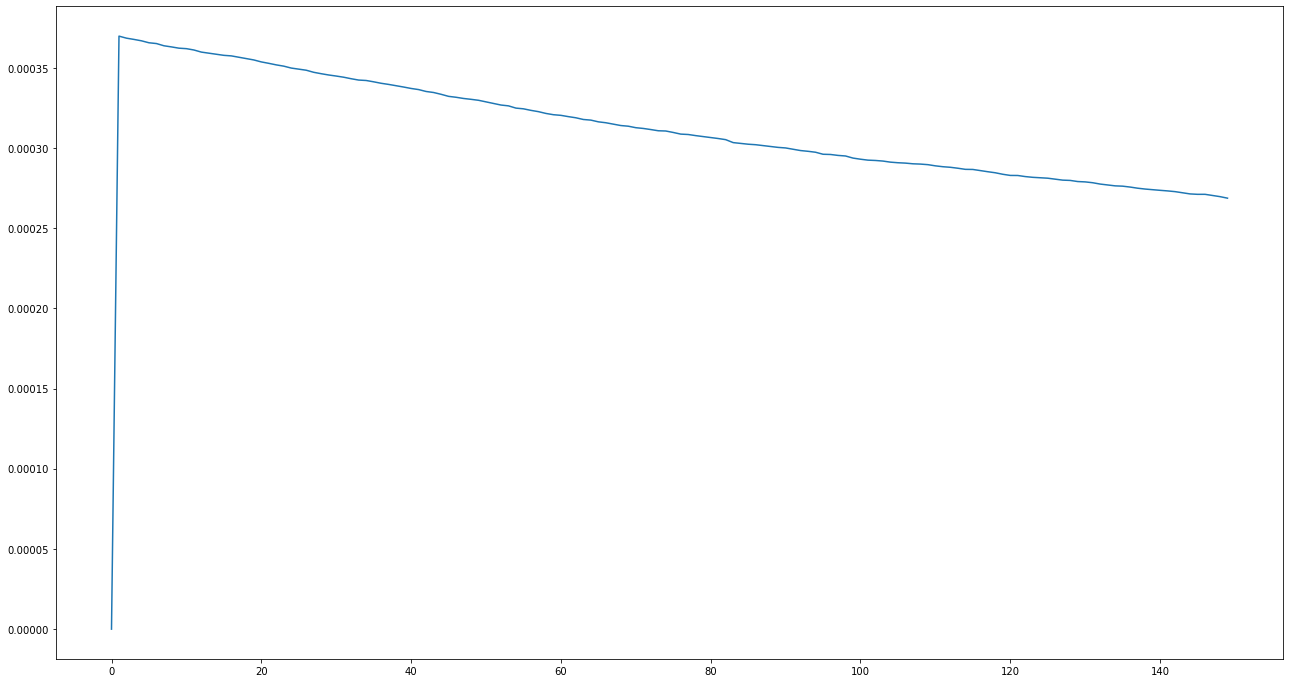

In [84]:
avg15 = 0
avgLossPerEpoch15 = []
for i in range(len(pltdata15)):
    avg15 = avg15 + pltdata15[i]
    if(i%780==0):
        avgLossPerEpoch15.append(avg15)
        avg15 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch15[0:150])       

learning rate  0.8
dev  cuda
[1,   100] loss: 0.0000000070
[1,   200] loss: 0.0000000067
[1,   300] loss: 0.0000000061
[1,   400] loss: 0.0000000077
[1,   500] loss: 0.0000000065
[1,   600] loss: 0.0000000072
[1,   700] loss: 0.0000000076
[2,   100] loss: 0.0000000070
[2,   200] loss: 0.0000000067
[2,   300] loss: 0.0000000061
[2,   400] loss: 0.0000000077
[2,   500] loss: 0.0000000065
[2,   600] loss: 0.0000000072
[2,   700] loss: 0.0000000076
[3,   100] loss: 0.0000000070
[3,   200] loss: 0.0000000067
[3,   300] loss: 0.0000000061
[3,   400] loss: 0.0000000077
[3,   500] loss: 0.0000000065
[3,   600] loss: 0.0000000071
[3,   700] loss: 0.0000000075
[4,   100] loss: 0.0000000070
[4,   200] loss: 0.0000000067
[4,   300] loss: 0.0000000061
[4,   400] loss: 0.0000000077
[4,   500] loss: 0.0000000065
[4,   600] loss: 0.0000000071
[4,   700] loss: 0.0000000075
[5,   100] loss: 0.0000000069
[5,   200] loss: 0.0000000067
[5,   300] loss: 0.0000000061
[5,   400] loss: 0.0000000077
[5,   500] 

[39,   100] loss: 0.0000000064
[39,   200] loss: 0.0000000062
[39,   300] loss: 0.0000000056
[39,   400] loss: 0.0000000070
[39,   500] loss: 0.0000000060
[39,   600] loss: 0.0000000066
[39,   700] loss: 0.0000000070
[40,   100] loss: 0.0000000064
[40,   200] loss: 0.0000000061
[40,   300] loss: 0.0000000056
[40,   400] loss: 0.0000000070
[40,   500] loss: 0.0000000060
[40,   600] loss: 0.0000000065
[40,   700] loss: 0.0000000070
[41,   100] loss: 0.0000000064
[41,   200] loss: 0.0000000061
[41,   300] loss: 0.0000000056
[41,   400] loss: 0.0000000070
[41,   500] loss: 0.0000000060
[41,   600] loss: 0.0000000065
[41,   700] loss: 0.0000000070
[42,   100] loss: 0.0000000064
[42,   200] loss: 0.0000000061
[42,   300] loss: 0.0000000056
[42,   400] loss: 0.0000000070
[42,   500] loss: 0.0000000060
[42,   600] loss: 0.0000000065
[42,   700] loss: 0.0000000070
[43,   100] loss: 0.0000000064
[43,   200] loss: 0.0000000061
[43,   300] loss: 0.0000000056
[43,   400] loss: 0.0000000070
[43,   5

[76,   700] loss: 0.0000000064
[77,   100] loss: 0.0000000059
[77,   200] loss: 0.0000000057
[77,   300] loss: 0.0000000053
[77,   400] loss: 0.0000000066
[77,   500] loss: 0.0000000056
[77,   600] loss: 0.0000000059
[77,   700] loss: 0.0000000063
[78,   100] loss: 0.0000000059
[78,   200] loss: 0.0000000057
[78,   300] loss: 0.0000000053
[78,   400] loss: 0.0000000065
[78,   500] loss: 0.0000000056
[78,   600] loss: 0.0000000059
[78,   700] loss: 0.0000000063
[79,   100] loss: 0.0000000059
[79,   200] loss: 0.0000000056
[79,   300] loss: 0.0000000052
[79,   400] loss: 0.0000000065
[79,   500] loss: 0.0000000055
[79,   600] loss: 0.0000000059
[79,   700] loss: 0.0000000063
[80,   100] loss: 0.0000000059
[80,   200] loss: 0.0000000056
[80,   300] loss: 0.0000000052
[80,   400] loss: 0.0000000065
[80,   500] loss: 0.0000000055
[80,   600] loss: 0.0000000059
[80,   700] loss: 0.0000000063
[81,   100] loss: 0.0000000059
[81,   200] loss: 0.0000000057
[81,   300] loss: 0.0000000052
[81,   4

[114,   300] loss: 0.0000000049
[114,   400] loss: 0.0000000059
[114,   500] loss: 0.0000000052
[114,   600] loss: 0.0000000055
[114,   700] loss: 0.0000000058
[115,   100] loss: 0.0000000056
[115,   200] loss: 0.0000000053
[115,   300] loss: 0.0000000049
[115,   400] loss: 0.0000000059
[115,   500] loss: 0.0000000052
[115,   600] loss: 0.0000000055
[115,   700] loss: 0.0000000058
[116,   100] loss: 0.0000000055
[116,   200] loss: 0.0000000053
[116,   300] loss: 0.0000000049
[116,   400] loss: 0.0000000058
[116,   500] loss: 0.0000000052
[116,   600] loss: 0.0000000055
[116,   700] loss: 0.0000000058
[117,   100] loss: 0.0000000055
[117,   200] loss: 0.0000000052
[117,   300] loss: 0.0000000048
[117,   400] loss: 0.0000000058
[117,   500] loss: 0.0000000052
[117,   600] loss: 0.0000000055
[117,   700] loss: 0.0000000057
[118,   100] loss: 0.0000000055
[118,   200] loss: 0.0000000053
[118,   300] loss: 0.0000000049
[118,   400] loss: 0.0000000058
[118,   500] loss: 0.0000000052
[118,   

Finished Training on GPU
Accuracy of plane : 89.09 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 78.48 %
Accuracy of   cat : 64.38 %
Accuracy of  deer : 81.82 %
Accuracy of   dog : 79.31 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 83.33 %
Accuracy of the network on the 9984 test images: 84.00 %


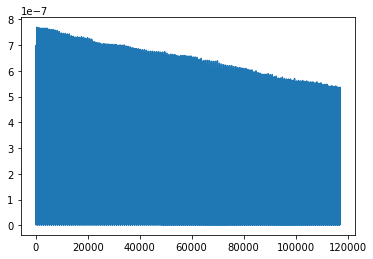

In [27]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.8)
pltdata16 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata16)

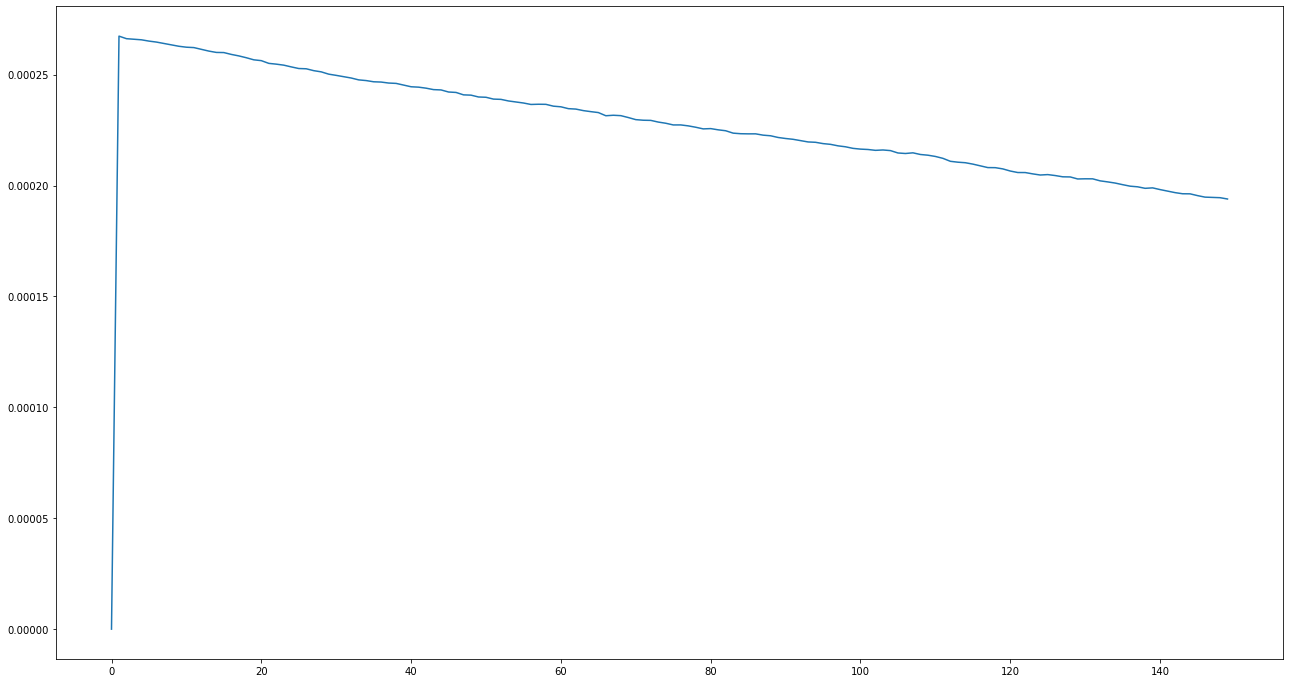

In [85]:
avg16 = 0
avgLossPerEpoch16 = []
for i in range(len(pltdata16)):
    avg16 = avg16 + pltdata16[i]
    if(i%780==0):
        avgLossPerEpoch16.append(avg16)
        avg16 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch16[0:150])       

learning rate  0.9
dev  cuda
[1,   100] loss: 0.0000000051
[1,   200] loss: 0.0000000048
[1,   300] loss: 0.0000000046
[1,   400] loss: 0.0000000054
[1,   500] loss: 0.0000000049
[1,   600] loss: 0.0000000050
[1,   700] loss: 0.0000000053
[2,   100] loss: 0.0000000051
[2,   200] loss: 0.0000000048
[2,   300] loss: 0.0000000046
[2,   400] loss: 0.0000000054
[2,   500] loss: 0.0000000049
[2,   600] loss: 0.0000000050
[2,   700] loss: 0.0000000053
[3,   100] loss: 0.0000000051
[3,   200] loss: 0.0000000048
[3,   300] loss: 0.0000000046
[3,   400] loss: 0.0000000053
[3,   500] loss: 0.0000000048
[3,   600] loss: 0.0000000050
[3,   700] loss: 0.0000000053
[4,   100] loss: 0.0000000051
[4,   200] loss: 0.0000000047
[4,   300] loss: 0.0000000046
[4,   400] loss: 0.0000000054
[4,   500] loss: 0.0000000048
[4,   600] loss: 0.0000000049
[4,   700] loss: 0.0000000053
[5,   100] loss: 0.0000000051
[5,   200] loss: 0.0000000047
[5,   300] loss: 0.0000000046
[5,   400] loss: 0.0000000053
[5,   500] 

[39,   100] loss: 0.0000000048
[39,   200] loss: 0.0000000043
[39,   300] loss: 0.0000000042
[39,   400] loss: 0.0000000049
[39,   500] loss: 0.0000000044
[39,   600] loss: 0.0000000044
[39,   700] loss: 0.0000000048
[40,   100] loss: 0.0000000047
[40,   200] loss: 0.0000000043
[40,   300] loss: 0.0000000042
[40,   400] loss: 0.0000000049
[40,   500] loss: 0.0000000044
[40,   600] loss: 0.0000000043
[40,   700] loss: 0.0000000049
[41,   100] loss: 0.0000000047
[41,   200] loss: 0.0000000042
[41,   300] loss: 0.0000000041
[41,   400] loss: 0.0000000049
[41,   500] loss: 0.0000000043
[41,   600] loss: 0.0000000043
[41,   700] loss: 0.0000000049
[42,   100] loss: 0.0000000047
[42,   200] loss: 0.0000000042
[42,   300] loss: 0.0000000042
[42,   400] loss: 0.0000000049
[42,   500] loss: 0.0000000043
[42,   600] loss: 0.0000000043
[42,   700] loss: 0.0000000049
[43,   100] loss: 0.0000000048
[43,   200] loss: 0.0000000042
[43,   300] loss: 0.0000000041
[43,   400] loss: 0.0000000049
[43,   5

[76,   700] loss: 0.0000000046
[77,   100] loss: 0.0000000043
[77,   200] loss: 0.0000000039
[77,   300] loss: 0.0000000038
[77,   400] loss: 0.0000000045
[77,   500] loss: 0.0000000039
[77,   600] loss: 0.0000000039
[77,   700] loss: 0.0000000046
[78,   100] loss: 0.0000000043
[78,   200] loss: 0.0000000039
[78,   300] loss: 0.0000000038
[78,   400] loss: 0.0000000045
[78,   500] loss: 0.0000000039
[78,   600] loss: 0.0000000039
[78,   700] loss: 0.0000000046
[79,   100] loss: 0.0000000043
[79,   200] loss: 0.0000000039
[79,   300] loss: 0.0000000038
[79,   400] loss: 0.0000000045
[79,   500] loss: 0.0000000039
[79,   600] loss: 0.0000000039
[79,   700] loss: 0.0000000045
[80,   100] loss: 0.0000000043
[80,   200] loss: 0.0000000039
[80,   300] loss: 0.0000000038
[80,   400] loss: 0.0000000045
[80,   500] loss: 0.0000000039
[80,   600] loss: 0.0000000038
[80,   700] loss: 0.0000000045
[81,   100] loss: 0.0000000043
[81,   200] loss: 0.0000000038
[81,   300] loss: 0.0000000038
[81,   4

[114,   300] loss: 0.0000000036
[114,   400] loss: 0.0000000040
[114,   500] loss: 0.0000000037
[114,   600] loss: 0.0000000036
[114,   700] loss: 0.0000000043
[115,   100] loss: 0.0000000040
[115,   200] loss: 0.0000000035
[115,   300] loss: 0.0000000035
[115,   400] loss: 0.0000000040
[115,   500] loss: 0.0000000037
[115,   600] loss: 0.0000000036
[115,   700] loss: 0.0000000043
[116,   100] loss: 0.0000000040
[116,   200] loss: 0.0000000035
[116,   300] loss: 0.0000000036
[116,   400] loss: 0.0000000040
[116,   500] loss: 0.0000000037
[116,   600] loss: 0.0000000036
[116,   700] loss: 0.0000000042
[117,   100] loss: 0.0000000040
[117,   200] loss: 0.0000000035
[117,   300] loss: 0.0000000036
[117,   400] loss: 0.0000000040
[117,   500] loss: 0.0000000037
[117,   600] loss: 0.0000000036
[117,   700] loss: 0.0000000042
[118,   100] loss: 0.0000000039
[118,   200] loss: 0.0000000034
[118,   300] loss: 0.0000000035
[118,   400] loss: 0.0000000040
[118,   500] loss: 0.0000000037
[118,   

Finished Training on GPU
Accuracy of plane : 89.09 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 78.48 %
Accuracy of   cat : 64.38 %
Accuracy of  deer : 81.82 %
Accuracy of   dog : 79.31 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 83.33 %
Accuracy of the network on the 9984 test images: 84.01 %


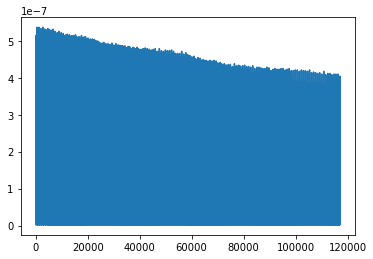

In [28]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.9)
pltdata17 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata17)

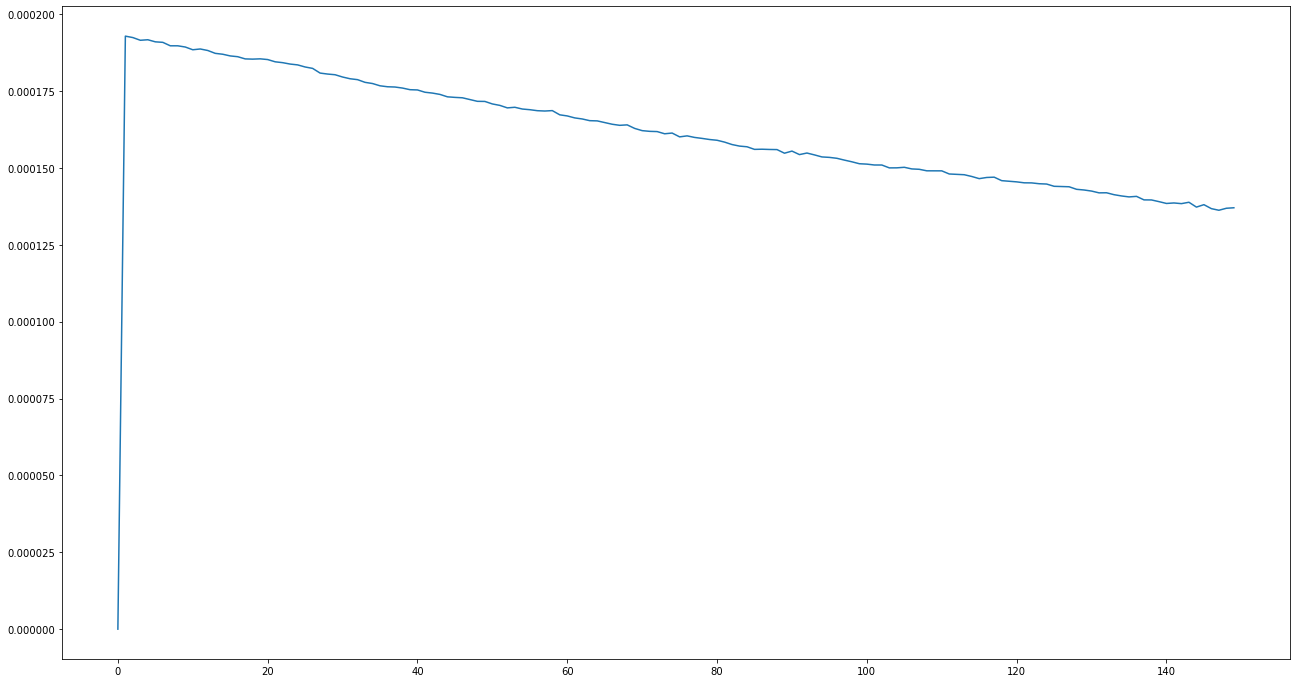

In [86]:
avg17 = 0
avgLossPerEpoch17 = []
for i in range(len(pltdata17)):
    avg17 = avg17 + pltdata17[i]
    if(i%780==0):
        avgLossPerEpoch17.append(avg17)
        avg17 = 0
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch17[0:150])       

learning rate  0.11
dev  cuda
[1,   100] loss: 0.0000000037
[1,   200] loss: 0.0000000033
[1,   300] loss: 0.0000000032
[1,   400] loss: 0.0000000038
[1,   500] loss: 0.0000000034
[1,   600] loss: 0.0000000032
[1,   700] loss: 0.0000000040
[2,   100] loss: 0.0000000037
[2,   200] loss: 0.0000000033
[2,   300] loss: 0.0000000032
[2,   400] loss: 0.0000000038
[2,   500] loss: 0.0000000034
[2,   600] loss: 0.0000000032
[2,   700] loss: 0.0000000040
[3,   100] loss: 0.0000000037
[3,   200] loss: 0.0000000033
[3,   300] loss: 0.0000000032
[3,   400] loss: 0.0000000038
[3,   500] loss: 0.0000000034
[3,   600] loss: 0.0000000032
[3,   700] loss: 0.0000000040
[4,   100] loss: 0.0000000037
[4,   200] loss: 0.0000000033
[4,   300] loss: 0.0000000032
[4,   400] loss: 0.0000000038
[4,   500] loss: 0.0000000034
[4,   600] loss: 0.0000000032
[4,   700] loss: 0.0000000040
[5,   100] loss: 0.0000000037
[5,   200] loss: 0.0000000033
[5,   300] loss: 0.0000000032
[5,   400] loss: 0.0000000038
[5,   500]

[39,   100] loss: 0.0000000036
[39,   200] loss: 0.0000000033
[39,   300] loss: 0.0000000032
[39,   400] loss: 0.0000000038
[39,   500] loss: 0.0000000034
[39,   600] loss: 0.0000000032
[39,   700] loss: 0.0000000040
[40,   100] loss: 0.0000000036
[40,   200] loss: 0.0000000033
[40,   300] loss: 0.0000000032
[40,   400] loss: 0.0000000038
[40,   500] loss: 0.0000000034
[40,   600] loss: 0.0000000032
[40,   700] loss: 0.0000000041
[41,   100] loss: 0.0000000036
[41,   200] loss: 0.0000000033
[41,   300] loss: 0.0000000032
[41,   400] loss: 0.0000000038
[41,   500] loss: 0.0000000034
[41,   600] loss: 0.0000000032
[41,   700] loss: 0.0000000041
[42,   100] loss: 0.0000000036
[42,   200] loss: 0.0000000033
[42,   300] loss: 0.0000000032
[42,   400] loss: 0.0000000038
[42,   500] loss: 0.0000000034
[42,   600] loss: 0.0000000032
[42,   700] loss: 0.0000000041
[43,   100] loss: 0.0000000036
[43,   200] loss: 0.0000000033
[43,   300] loss: 0.0000000032
[43,   400] loss: 0.0000000037
[43,   5

[76,   700] loss: 0.0000000041
[77,   100] loss: 0.0000000036
[77,   200] loss: 0.0000000033
[77,   300] loss: 0.0000000032
[77,   400] loss: 0.0000000038
[77,   500] loss: 0.0000000033
[77,   600] loss: 0.0000000032
[77,   700] loss: 0.0000000040
[78,   100] loss: 0.0000000036
[78,   200] loss: 0.0000000033
[78,   300] loss: 0.0000000032
[78,   400] loss: 0.0000000037
[78,   500] loss: 0.0000000034
[78,   600] loss: 0.0000000032
[78,   700] loss: 0.0000000041
[79,   100] loss: 0.0000000036
[79,   200] loss: 0.0000000033
[79,   300] loss: 0.0000000032
[79,   400] loss: 0.0000000038
[79,   500] loss: 0.0000000034
[79,   600] loss: 0.0000000032
[79,   700] loss: 0.0000000041
[80,   100] loss: 0.0000000036
[80,   200] loss: 0.0000000032
[80,   300] loss: 0.0000000032
[80,   400] loss: 0.0000000038
[80,   500] loss: 0.0000000033
[80,   600] loss: 0.0000000032
[80,   700] loss: 0.0000000041
[81,   100] loss: 0.0000000036
[81,   200] loss: 0.0000000033
[81,   300] loss: 0.0000000032
[81,   4

[114,   300] loss: 0.0000000032
[114,   400] loss: 0.0000000038
[114,   500] loss: 0.0000000033
[114,   600] loss: 0.0000000032
[114,   700] loss: 0.0000000041
[115,   100] loss: 0.0000000036
[115,   200] loss: 0.0000000033
[115,   300] loss: 0.0000000032
[115,   400] loss: 0.0000000038
[115,   500] loss: 0.0000000033
[115,   600] loss: 0.0000000032
[115,   700] loss: 0.0000000041
[116,   100] loss: 0.0000000036
[116,   200] loss: 0.0000000032
[116,   300] loss: 0.0000000032
[116,   400] loss: 0.0000000038
[116,   500] loss: 0.0000000033
[116,   600] loss: 0.0000000032
[116,   700] loss: 0.0000000041
[117,   100] loss: 0.0000000036
[117,   200] loss: 0.0000000032
[117,   300] loss: 0.0000000032
[117,   400] loss: 0.0000000038
[117,   500] loss: 0.0000000033
[117,   600] loss: 0.0000000032
[117,   700] loss: 0.0000000041
[118,   100] loss: 0.0000000036
[118,   200] loss: 0.0000000033
[118,   300] loss: 0.0000000032
[118,   400] loss: 0.0000000038
[118,   500] loss: 0.0000000033
[118,   

Finished Training on GPU
Accuracy of plane : 89.09 %
Accuracy of   car : 90.00 %
Accuracy of  bird : 78.48 %
Accuracy of   cat : 64.38 %
Accuracy of  deer : 81.82 %
Accuracy of   dog : 79.31 %
Accuracy of  frog : 89.29 %
Accuracy of horse : 87.30 %
Accuracy of  ship : 92.98 %
Accuracy of truck : 83.33 %
Accuracy of the network on the 9984 test images: 84.01 %


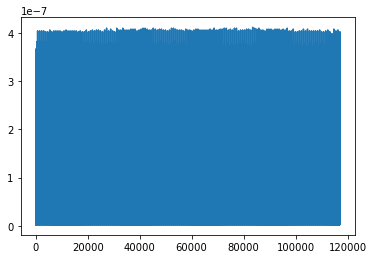

In [29]:
optimizer=useOptimizerFunction('SGD',learning_rate=0.11)
pltdata18 = trainNetworkOnGPU(max_epoch_num, x_train_gpu,y_train_gpu,optimizer,criterion,device)
AccuracyOfIndividualClassesAndDataset(x_test_gpu,y_test_gpu,batch_size)
plt.plot(pltdata18)

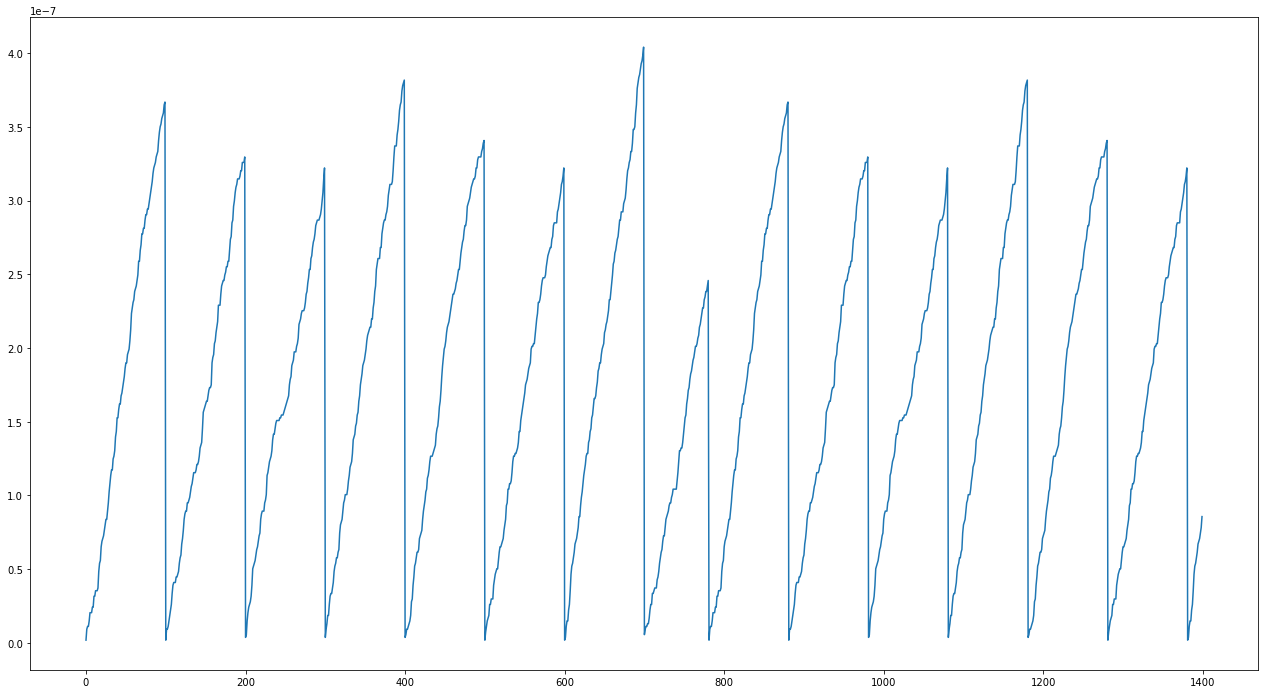

In [40]:
plt.figure(figsize=(22, 12))
plt.plot(pltdata18[0:1400])

In [94]:
avg18 = 0
avgLossPerEpoch18 = []
for i in range(len(pltdata18)):
    avg18 = avg18 + pltdata18[i]
    if(i%780==0):
        avgLossPerEpoch18.append(avg18)
        avg18 = 0

In [95]:
len(avgLossPerEpoch18)

151

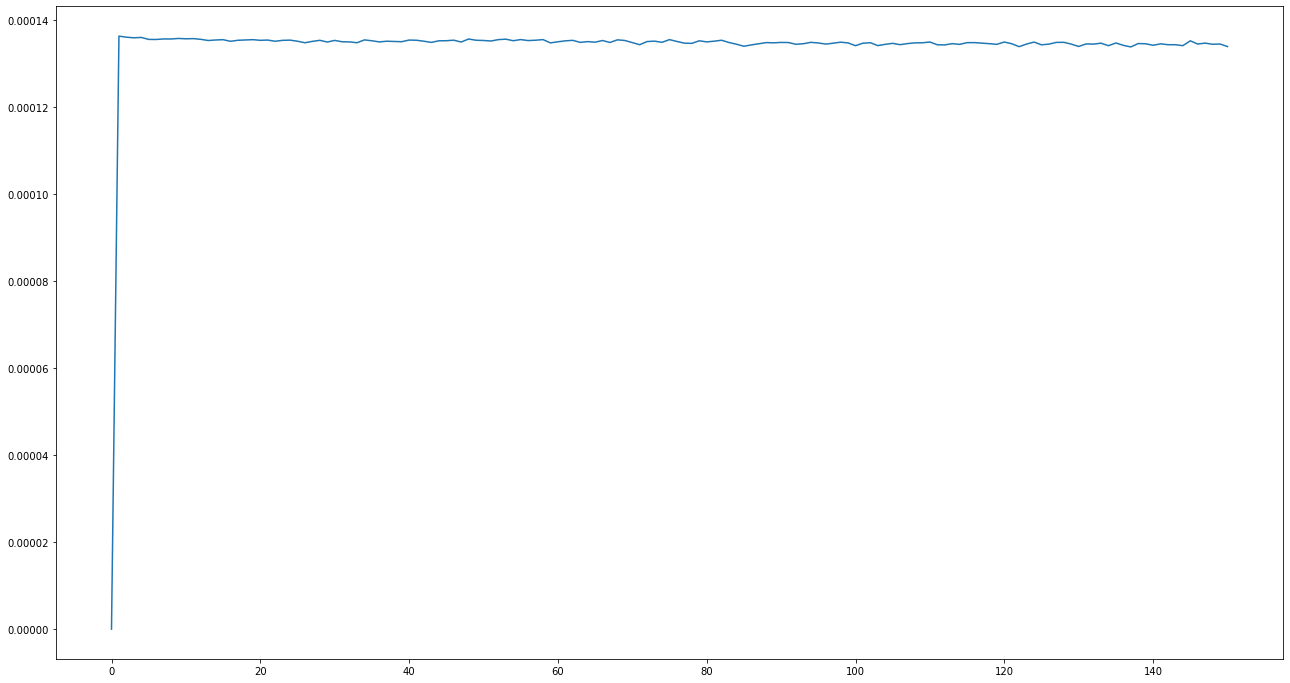

In [96]:
plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch18)

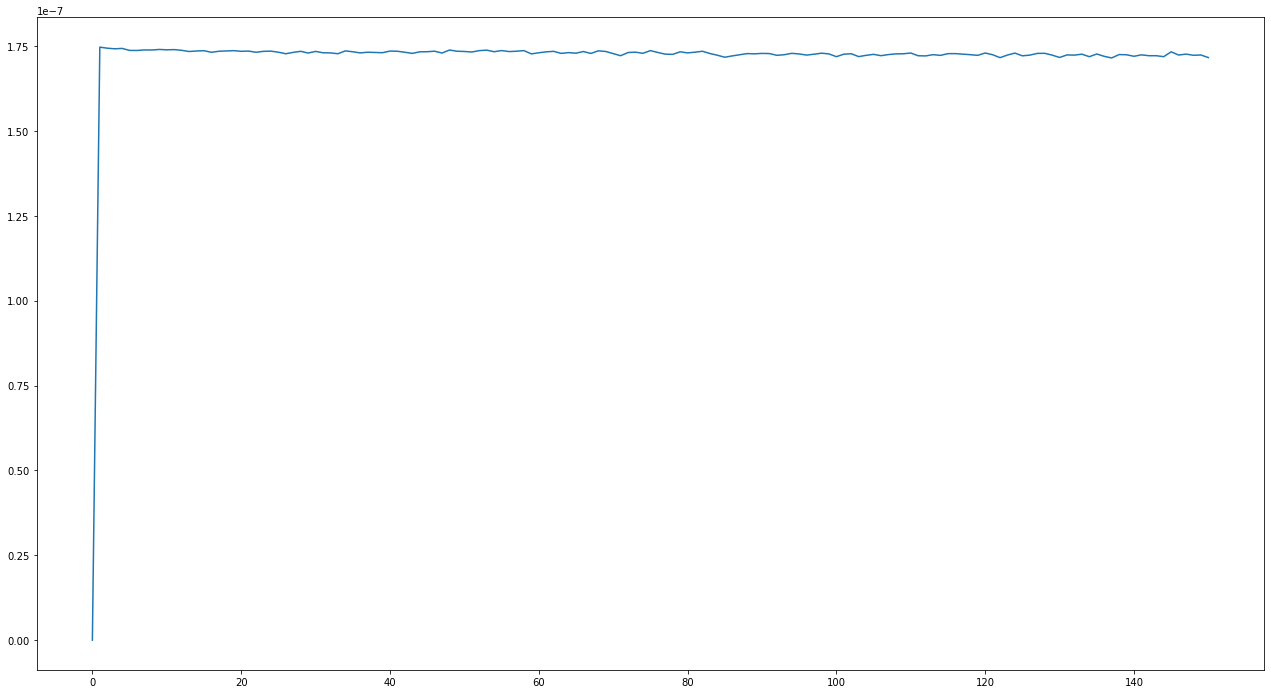

In [99]:
avg18 = 0
avgLossPerEpoch18 = []
for i in range(len(pltdata18)):
    avg18 = avg18 + pltdata18[i]
    if(i%780==0):
        avgLossPerEpoch18.append(avg18/780)
        avg18 = 0

plt.figure(figsize=(22, 12))
plt.plot(avgLossPerEpoch18)

#END